# Homework 2 (Part 1 & Part 2)

# Part 1
### Volkov Dmitry

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import scipy.stats as ss
from arch import arch_model 
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
seed = 1000 - 7 
np.random.seed(seed)
plt.rcParams['figure.dpi'] = 200
colors = ['#006699', '#FFC72C', '#F25022']
warnings.filterwarnings("ignore")

In [2]:
TICKERS = ['IBM','MCD','MSFT']
start = '2017-07-01'
end = '2020-06-30'
prices = yf.download(TICKERS, start, end, group_by='column')['Adj Close']
prices.index = prices.index.to_period(freq='d')

returns = prices.pct_change().dropna()

[*********************100%***********************]  3 of 3 completed


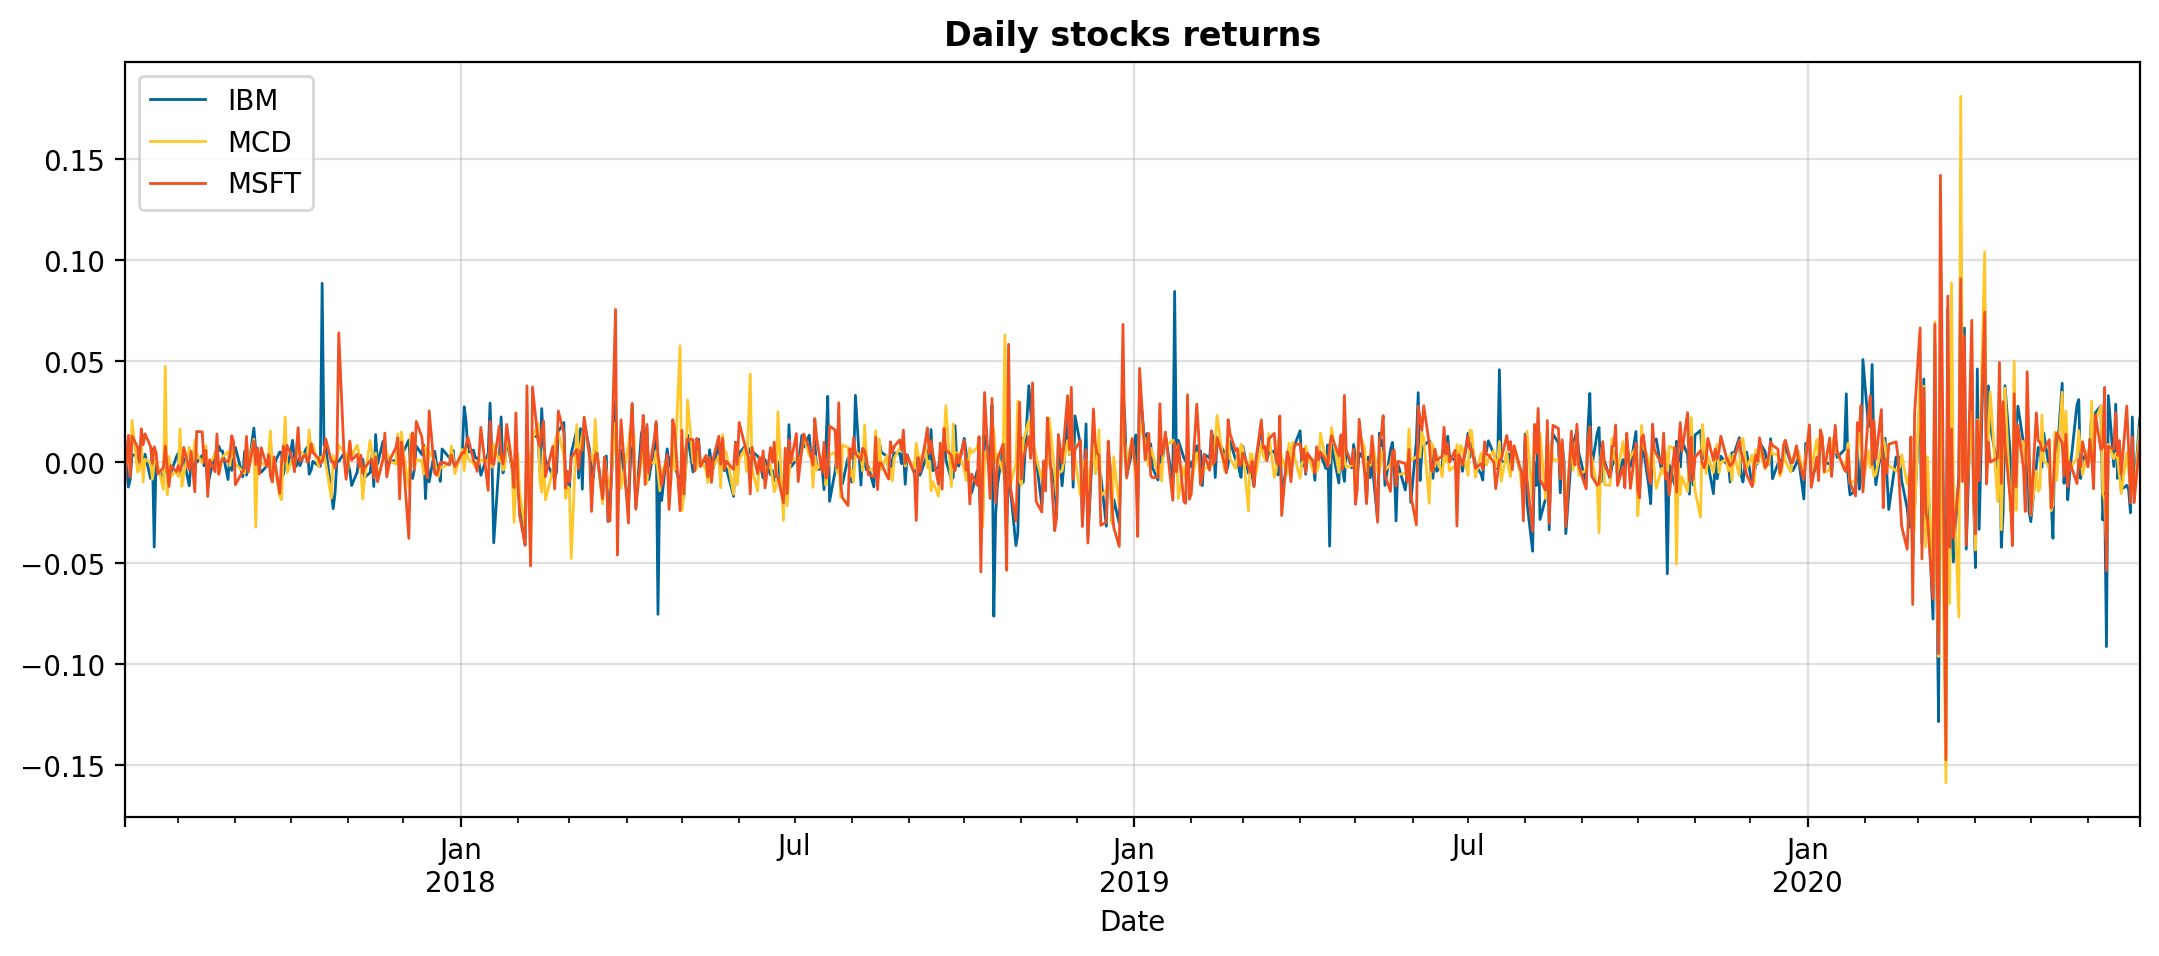

In [3]:
returns.plot(figsize=(13, 5), linewidth=1, color=colors)
plt.title("Daily stocks returns", weight="bold")
plt.grid(alpha=.4)
plt.show()

In [4]:
w = 1 / prices.iloc[0]
w = w / w.sum()
w.name = 'Portfolio weights'
port_real_ret = pd.Series(np.dot(returns.values, w), index=returns.index)

print(w)

IBM     0.259473
MCD     0.236748
MSFT    0.503780
Name: Portfolio weights, dtype: float64


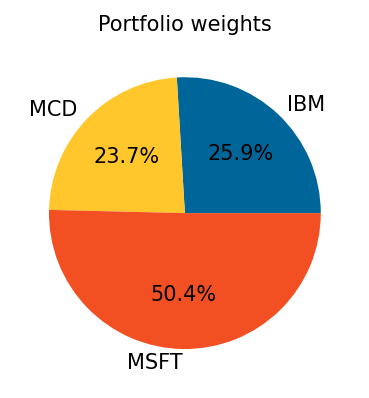

In [5]:
plt.figure(figsize=(3, 3), dpi=150)
plt.pie(w, labels=w.index, autopct=lambda pct: f"{pct:.1f}%", colors=colors)
plt.title("Portfolio weights", fontsize=10)
plt.show()

## 1. Calculations of VaRs

### 1.1 Using multivariate normal 

In [6]:
def calc_VaR(returns: np.array, sampling_fun, w, L_history=252, level=0.05)-> pd.core.series.Series:
    VaR = np.full(returns.shape[0], np.nan)
    for i in tqdm(range(L_history, returns.shape[0])):
        history = returns[i - L_history: i]
        try:
            return_simulations = sampling_fun(history)
            portfolio_simulated_returns = np.dot(return_simulations.values, w)
            VaR[i] = np.quantile(portfolio_simulated_returns, level)
        except:
            VaR[i] = VaR[i-1]
    return pd.Series(data=VaR, index=returns.index, name=sampling_fun.__name__).dropna()

In [7]:
def VaR_mult_normal_simulations(returns: np.array, n_samples=10**3)-> pd.core.series.Series:
    mean = np.mean(returns.values, axis=0)
    cov = np.cov(returns.values, rowvar=False)
    return_simulations = ss.multivariate_normal.rvs(mean=mean, cov=cov, size=n_samples, random_state=42)
    return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)
    return return_simulations

In [8]:
VaR_multy_normal = calc_VaR(returns, VaR_mult_normal_simulations, w)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 736.39it/s]


### 1.2 Historical simulation.

In [9]:
def calculate_VaR_HS(returns: np.array, alpha=0.05):
    return returns.quantile(alpha)

In [10]:
VaR_HS = calc_VaR(returns, calculate_VaR_HS, w)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 1586.16it/s]


### 1.3 ES curves calculations for bouth approaches
**NOTE:**

Expected Shortfall (ES), also known as  Conditional Value at Risk (CVaR)

In [11]:
def calc_ES(returns: np.array, sampling_fun, w, L_history=252, level=0.05)-> pd.core.series.Series:
    ES = np.full(returns.shape[0], np.nan)
    for i in tqdm(range(L_history, returns.shape[0])):
        history = returns[i - L_history: i]
        try:
            return_simulations = sampling_fun(history)
            portfolio_simulated_returns = np.dot(return_simulations.values, w)
            qw = np.quantile(portfolio_simulated_returns, level) 
            ES[i] = portfolio_simulated_returns[portfolio_simulated_returns <= qw].mean()
        except:
            ES[i] = ES[i-1]
    return pd.Series(data=ES, index=returns.index, name=sampling_fun.__name__).dropna()

In [12]:
ES_HS = calc_ES(returns, calculate_VaR_HS, w)
ES_multy_normal = calc_ES(returns, VaR_mult_normal_simulations, w)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 887.90it/s]


## 2. Results

### 2.1 Plotting VaR & ES curves
Cutting the first 252 trading days for higher resolution.

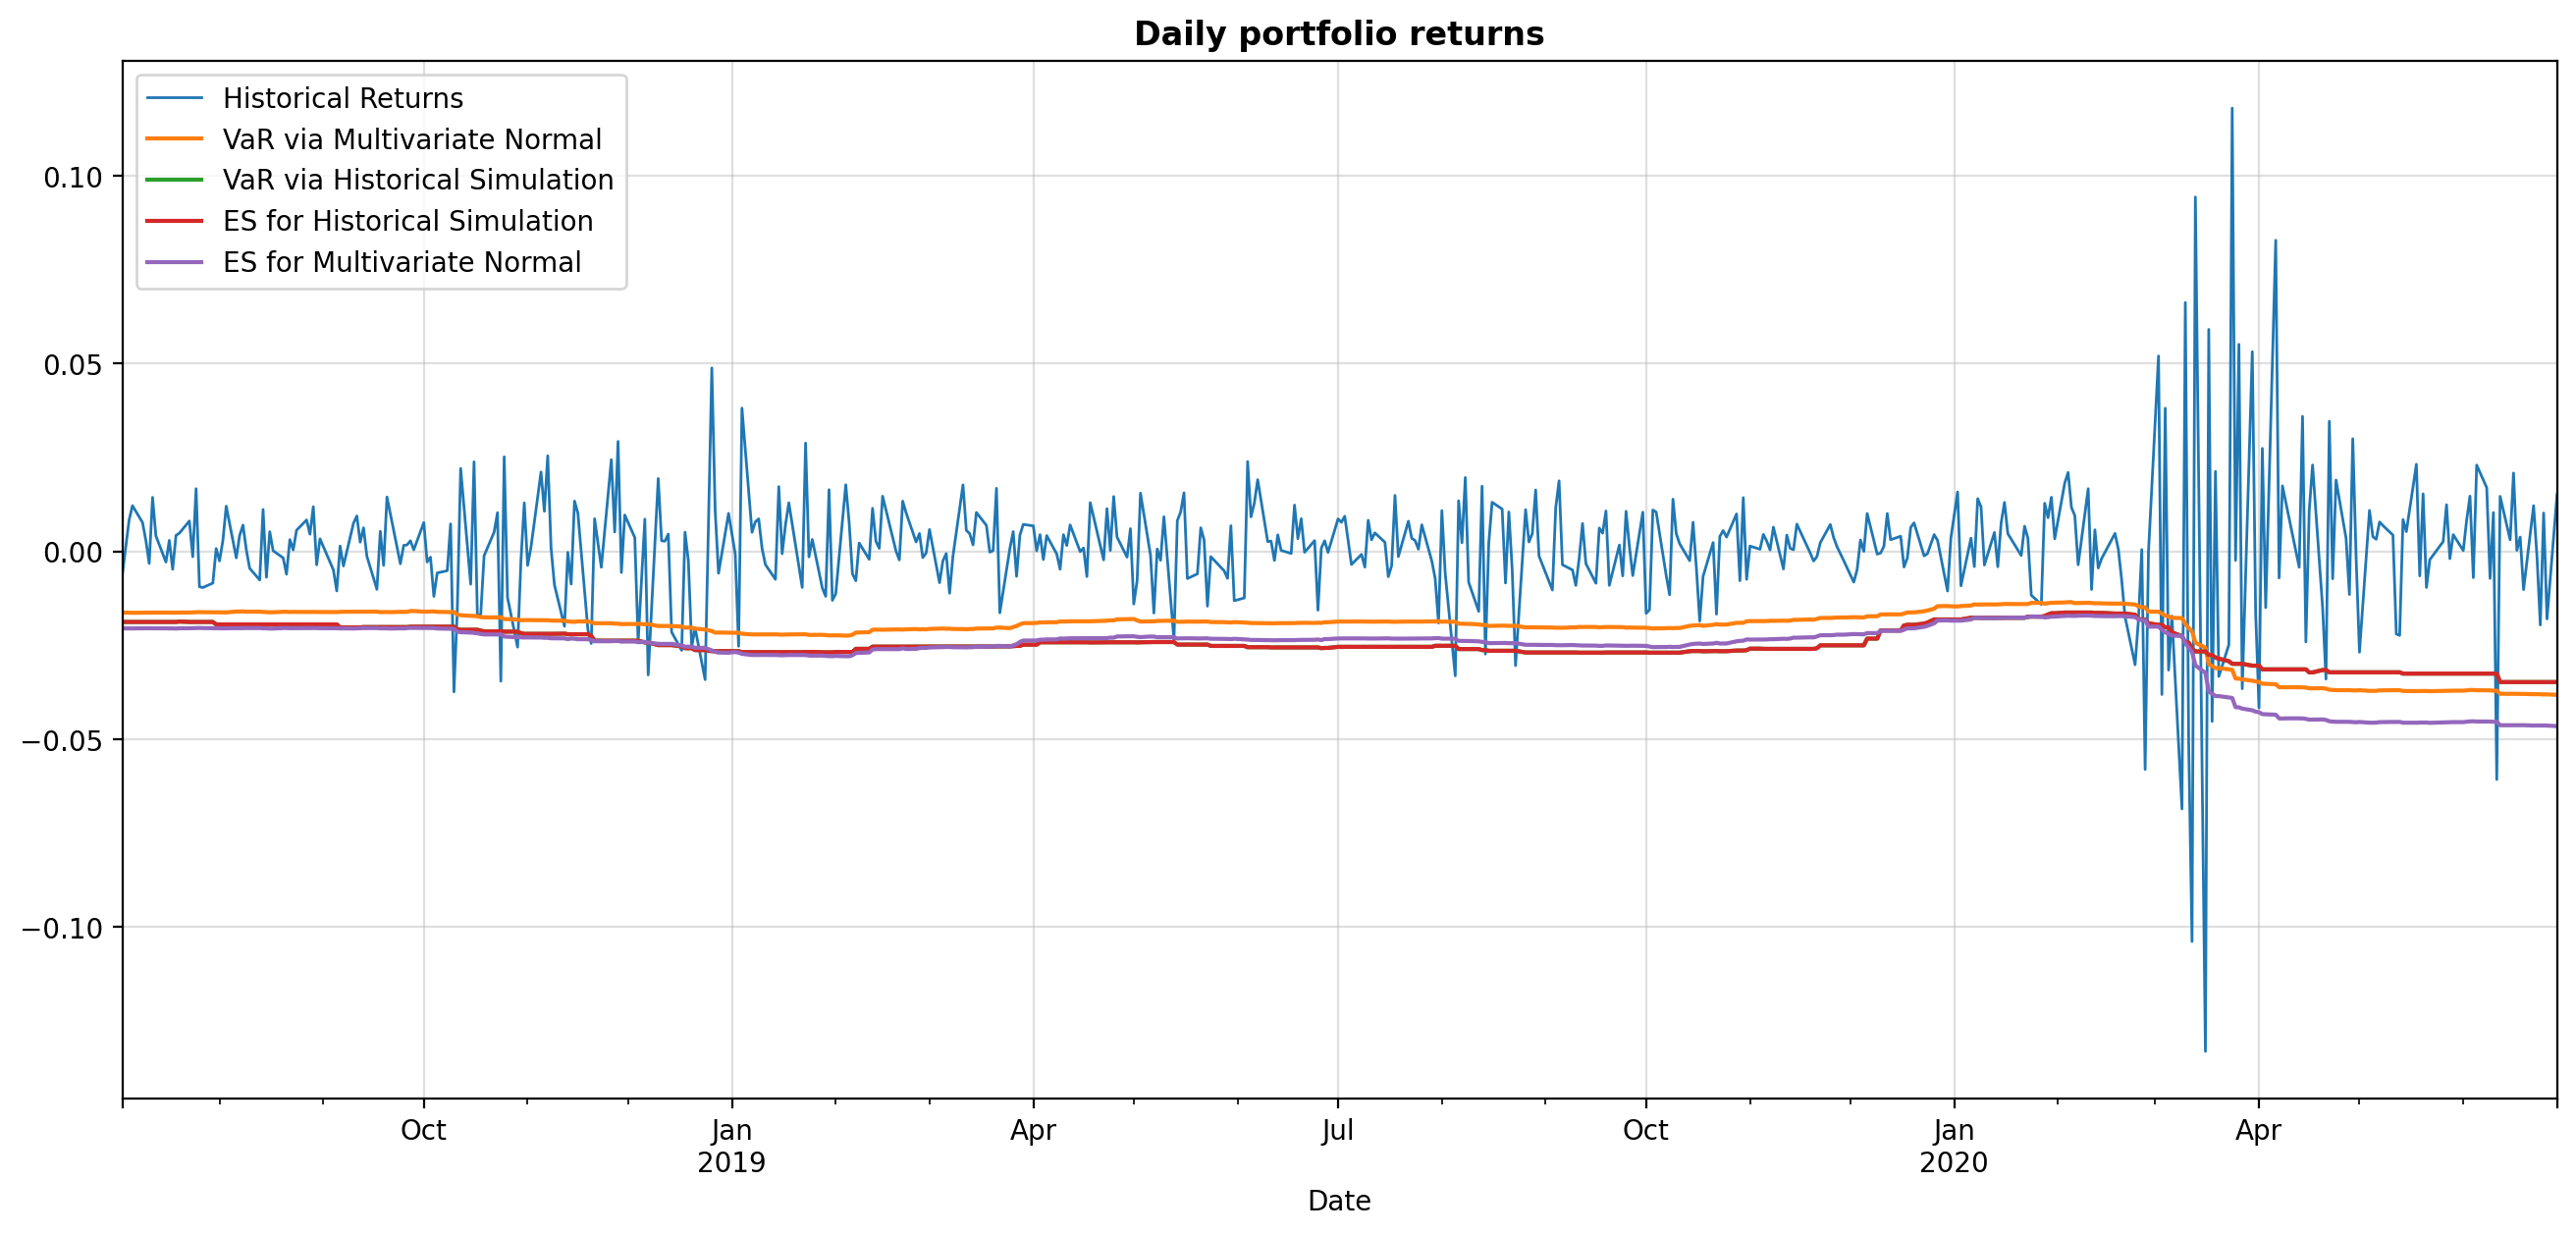

In [13]:
fig = plt.figure(figsize=(16, 7))
port_real_ret[252:].plot(linewidth=1, label='Historical Returns')
VaR_multy_normal.plot(label='VaR via Multivariate Normal')
VaR_HS.plot(label='VaR via Historical Simulation')

ES_HS.plot(label='ES for Historical Simulation')
ES_multy_normal.plot(label='ES for Multivariate Normal')

plt.title("Daily portfolio returns", weight="bold")
plt.grid(alpha=.4)
plt.legend()
plt.show()

### 2.2 Backtesting VaR & ES

In [14]:
def calc_hits(returns, VaRs):
    return ((VaRs - returns).dropna() > 0).values

def zone(p):
    if p > 0.05:
        return 'green'
    elif p > 0.0001:
        return 'yellow'
    else:
        return 'red'

In [15]:
def backtest(returns, VaR, level, L=None):
    # to skip starting NaNs
    if L is None:
        L = (~VaR.isna()).to_numpy().nonzero()[0][0];
    returns = returns[L:]
    VaR = VaR[L:]
    
    hits = calc_hits(returns, VaR)    
    
    prop_of_hits = (sum(hits)/len(hits))*100
    p_value_two_sided = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'two-sided')
    p_value_conservative = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'greater')
    print(f'Backtesting {VaR.name}:')
    print(f'The proportion of hits is {prop_of_hits:.3}% instead of expected {(1-level)*100:.3}%')
    print(f'Two-sided p-val {p_value_two_sided:.3}, one-sided: {p_value_conservative:.3}')
    print(f'{zone(p_value_two_sided)} zone\n' + 32 * '--'+ '\n')
    return prop_of_hits, p_value_conservative

In [16]:
backtest(port_real_ret, VaR_HS, .95)
backtest(port_real_ret, VaR_multy_normal, .95)

Backtesting calculate_VaR_HS:
The proportion of hits is 5.39% instead of expected 5.0%
Two-sided p-val 0.681, one-sided: 0.373
green zone
----------------------------------------------------------------

Backtesting VaR_mult_normal_simulations:
The proportion of hits is 6.79% instead of expected 5.0%
Two-sided p-val 0.08, one-sided: 0.0465
green zone
----------------------------------------------------------------



(6.786427145708583, 0.04645974077632845)

### 2.3 Conclusion

As we may see from the backtesting, results given by simple historical simulations over the time period of 252 trading days shows better results compared to simulations of VaR via normal distribution. For historical simulations, the proportion of hits is lower by `1.4%` (`5.39%` vs `6.79%`) and also p-value is superiorly better (`0.68` compared to `0.08` for the second approach). We may conclude for this particular portfolio VaR estimation via historical simulations is more preferable.

---

# Part 2

## 1. Calculations of VaRs
### 1.1 GMM model. 
Select the optimal number of components using AIC or BIC criteria

In [17]:
def make_gmm_simulations_5(returns, n_samples=10**3, n_components=5):
    gmm = GaussianMixture(n_components=n_components,
                          covariance_type='full',
                          n_init=3, random_state=seed) # full spherical
    gmm.fit(returns.values)
    return_simulations = gmm.sample(n_samples=n_samples)[0]
    return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)
    return return_simulations

def make_gmm_simulations_6(returns, n_samples=10**3, n_components=6):
    gmm = GaussianMixture(n_components=n_components,
                          covariance_type='full',
                          n_init=3, random_state=seed) # full spherical
    gmm.fit(returns.values)
    return_simulations = gmm.sample(n_samples=n_samples)[0]
    return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)
    return return_simulations

def make_gmm_simulations_7(returns, n_samples=10**3, n_components=7):
    gmm = GaussianMixture(n_components=n_components,
                          covariance_type='full',
                          n_init=3, random_state=seed) # full spherical
    gmm.fit(returns.values)
    return_simulations = gmm.sample(n_samples=n_samples)[0]
    return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)
    return return_simulations


def make_gmm_simulations_8(returns, n_samples=10**3, n_components=8):
    gmm = GaussianMixture(n_components=n_components,
                          covariance_type='full',
                          n_init=3, random_state=seed) # full spherical
    gmm.fit(returns.values)
    return_simulations = gmm.sample(n_samples=n_samples)[0]
    return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)
    return return_simulations

In [18]:
VaR_gmm_5 = calc_VaR(returns, make_gmm_simulations_5, w)
VaR_gmm_6 = calc_VaR(returns, make_gmm_simulations_6, w)
VaR_gmm_7 = calc_VaR(returns, make_gmm_simulations_7, w)
VaR_gmm_8 = calc_VaR(returns, make_gmm_simulations_8, w)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [00:44<00:00, 11.26it/s]


### 1.2 Copula+GARCH model with constant mean, EGARCH(2, 1, 2) and skewed t-student distribution of residuals.
Select the optimal copula type (fit different copula models and select the one with the highest Log Likelihood)

In [19]:
from copulae import StudentCopula, ClaytonCopula, GumbelCopula, NormalCopula

In [20]:
def get_garch_residuals(ret, dist):
    scaling_const = 10.0 / ret.std()
    # объявляем GARCH модель        
    am = arch_model(ret * scaling_const,
                    mean='Constant', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='HARCH', p=2, o=1, q=2, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged
    # фитим модель на данных
    res = am.fit(update_freq=0, disp='off')

    # сохраняем ее распределение
    if dist == 'Normal':
        cdf = am.distribution.cdf(res.resid.dropna())
    elif dist == 't' or dist == 'ged':
        cdf = am.distribution.cdf(res.resid.dropna(), res.params[-1:])
    elif dist == 'skewstudent':
        cdf = am.distribution.cdf(res.resid.dropna(), res.params[-2:])     
    return cdf, am, res, scaling_const


def make_garch_forecast(copula_simulation, dist, garch_object, garch_model, scaling_const):
    # делаем прогноз среднего и дисперсии
    forecasts = garch_object.forecast(horizon=1)
    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])
    # получаем из сэплов квантили сэмплы доходностей
    if dist == 'Normal':
        q = garch_model.distribution.ppf(copula_simulation)
    elif dist == 't' or dist == 'ged':
        q = garch_model.distribution.ppf(copula_simulation, garch_object.params[-1:])
    elif dist == 'skewstudent':
        q = garch_model.distribution.ppf(copula_simulation, garch_object.params[-2:])

    # и по формуле считаем ВаР
    return (cond_mean + np.sqrt(cond_var) * q) / scaling_const

def make_copula_simulation(returns, copula_func, n_samples, univariate_dist, dist='skewstudent'):
    # объявляем копулу
    cop = copula_func(dim=returns.shape[1])
    cdfs = returns.copy()
    distribution_params = {}
    # моделируем частные распределения для каждой акции
    for col in cdfs.columns:
        if univariate_dist == 't':
            t_df, t_mean, t_sigma = scipy.stats.t.fit(returns[col])
            distribution_params[col] = (t_df, t_mean, t_sigma)
            cdfs[col] = scipy.stats.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)
        elif univariate_dist == 'gennorm':
            beta, loc, scale = scipy.stats.gennorm.fit(returns[col])
            distribution_params[col] = (beta, loc, scale)
            cdfs[col] = scipy.stats.gennorm.cdf(cdfs[col], beta, loc, scale)
        elif univariate_dist == 'garch':
            cdf, am, res, scaling_const = get_garch_residuals(returns[col], dist)
            distribution_params[col] = (am, res, scaling_const)
#             cdf = np.append(cdf, cdf.mean())
            cdfs[col] = cdf
    # фитим копулу
    cop.fit(cdfs)
    
    # делаем сэмплирование квантилей из совместного распределения копулы
    copula_simulations = cop.random(n_samples, seed=42)
    copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)
    return_simulations = copula_simulations.copy()
    # трансформируем квантили в доходности с помощью частных функций распределений из первого шага
    for col in cdfs.columns:
        if univariate_dist == 't':
            t_df, t_mean, t_sigma = distribution_params[col]
            return_simulations[col] = scipy.stats.t.ppf(copula_simulations[col], df=t_df, loc=t_mean, scale=t_sigma)
        elif univariate_dist == 'gennorm':
            beta, loc, scale = distribution_params[col]
            return_simulations[col] = scipy.stats.gennorm.ppf(copula_simulations[col], beta, loc, scale)

        elif univariate_dist == 'garch':
            am, res, scaling_const = distribution_params[col]
            return_simulations[col] = make_garch_forecast(copula_simulations[col], dist, res, am, scaling_const)    
    # возвращаем матрицу сэмплированных доходностей
    return return_simulations

In [21]:
def make_copula_norm(returns):
    return_simulations = make_copula_simulation(returns, NormalCopula,
                                            n_samples=10**3, univariate_dist='garch')
    return return_simulations

def make_copula_clayton(returns):
    return_simulations = make_copula_simulation(returns, ClaytonCopula,
                                            n_samples=10**3, univariate_dist='garch')
    return return_simulations

VaR_copula_norm = calc_VaR(returns, make_copula_norm, w)

VaR_copula_clayton = calc_VaR(returns, make_copula_clayton, w)


  0%|▏                                                                                                         | 1/501 [00:00<02:00,  4.14it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  0%|▍                                                                                                         | 2/501 [00:00<01:58,  4.20it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  1%|▋                                                                                                         | 3/501 [00:00<02:04,  4.01it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  1%|▊                                                                                                         | 4/501 [00:00<02:04,  4.00it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  1%|█                                                                                                         | 5/501 [00:01<01:59,  4.17it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  1%|█▎                                                                                                        | 6/501 [00:01<01:58,  4.19it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  1%|█▍                                                                                                        | 7/501 [00:01<02:04,  3.98it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  2%|█▋                                                                                                        | 8/501 [00:01<02:02,  4.03it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  2%|█▉                                                                                                        | 9/501 [00:02<01:59,  4.13it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  2%|██                                                                                                       | 10/501 [00:02<02:01,  4.05it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  2%|██▎                                                                                                      | 11/501 [00:02<02:01,  4.03it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  2%|██▌                                                                                                      | 12/501 [00:02<02:04,  3.92it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  3%|██▋                                                                                                      | 13/501 [00:03<02:05,  3.88it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  3%|██▉                                                                                                      | 14/501 [00:03<02:05,  3.89it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  3%|███▏                                                                                                     | 15/501 [00:03<02:00,  4.02it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  3%|███▎                                                                                                     | 16/501 [00:03<01:57,  4.13it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  3%|███▌                                                                                                     | 17/501 [00:04<01:54,  4.21it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  4%|███▊                                                                                                     | 18/501 [00:04<01:57,  4.09it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  4%|███▉                                                                                                     | 19/501 [00:04<01:56,  4.13it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  4%|████▏                                                                                                    | 20/501 [00:04<01:56,  4.11it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  4%|████▍                                                                                                    | 21/501 [00:05<01:54,  4.19it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  4%|████▌                                                                                                    | 22/501 [00:05<01:52,  4.26it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  5%|████▊                                                                                                    | 23/501 [00:05<01:56,  4.11it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  5%|█████                                                                                                    | 24/501 [00:05<01:58,  4.02it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  5%|█████▏                                                                                                   | 25/501 [00:06<01:57,  4.06it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  5%|█████▍                                                                                                   | 26/501 [00:06<01:51,  4.25it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  5%|█████▋                                                                                                   | 27/501 [00:06<01:49,  4.34it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  6%|█████▊                                                                                                   | 28/501 [00:06<01:47,  4.41it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  6%|██████                                                                                                   | 29/501 [00:07<01:46,  4.43it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  6%|██████▎                                                                                                  | 30/501 [00:07<01:45,  4.46it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  6%|██████▍                                                                                                  | 31/501 [00:07<01:44,  4.51it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  6%|██████▋                                                                                                  | 32/501 [00:07<01:42,  4.56it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  7%|███████▏                                                                                                 | 34/501 [00:08<01:40,  4.66it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  7%|███████▎                                                                                                 | 35/501 [00:08<01:40,  4.62it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  7%|███████▌                                                                                                 | 36/501 [00:08<01:45,  4.39it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  7%|███████▊                                                                                                 | 37/501 [00:08<01:45,  4.39it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  8%|███████▉                                                                                                 | 38/501 [00:09<01:44,  4.43it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  8%|████████▏                                                                                                | 39/501 [00:09<01:41,  4.54it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  8%|████████▍                                                                                                | 40/501 [00:09<01:41,  4.55it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  8%|████████▌                                                                                                | 41/501 [00:09<01:39,  4.61it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  8%|████████▊                                                                                                | 42/501 [00:09<01:43,  4.43it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  9%|█████████                                                                                                | 43/501 [00:10<01:44,  4.37it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  9%|█████████▏                                                                                               | 44/501 [00:10<01:42,  4.44it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  9%|█████████▍                                                                                               | 45/501 [00:10<01:41,  4.48it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  9%|█████████▋                                                                                               | 46/501 [00:10<01:43,  4.40it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  9%|█████████▊                                                                                               | 47/501 [00:11<01:44,  4.33it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 10%|██████████                                                                                               | 48/501 [00:11<01:43,  4.39it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 10%|██████████▎                                                                                              | 49/501 [00:11<01:40,  4.52it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 10%|██████████▍                                                                                              | 50/501 [00:11<01:42,  4.41it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 10%|██████████▋                                                                                              | 51/501 [00:11<01:43,  4.36it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 10%|██████████▉                                                                                              | 52/501 [00:12<01:40,  4.45it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 11%|███████████                                                                                              | 53/501 [00:12<01:41,  4.39it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 11%|███████████▎                                                                                             | 54/501 [00:12<01:43,  4.32it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 11%|███████████▌                                                                                             | 55/501 [00:12<01:42,  4.35it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 11%|███████████▋                                                                                             | 56/501 [00:13<01:39,  4.45it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 11%|███████████▉                                                                                             | 57/501 [00:13<01:38,  4.53it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 12%|████████████▏                                                                                            | 58/501 [00:13<01:41,  4.38it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 12%|████████████▎                                                                                            | 59/501 [00:13<01:43,  4.28it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 12%|████████████▌                                                                                            | 60/501 [00:13<01:41,  4.33it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 12%|████████████▊                                                                                            | 61/501 [00:14<01:43,  4.26it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 12%|████████████▉                                                                                            | 62/501 [00:14<01:40,  4.36it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 13%|█████████████▏                                                                                           | 63/501 [00:14<01:38,  4.45it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 13%|█████████████▍                                                                                           | 64/501 [00:14<01:37,  4.50it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 13%|█████████████▌                                                                                           | 65/501 [00:15<01:38,  4.41it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 13%|█████████████▊                                                                                           | 66/501 [00:15<01:37,  4.45it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 13%|██████████████                                                                                           | 67/501 [00:15<01:37,  4.47it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 14%|██████████████▎                                                                                          | 68/501 [00:15<01:36,  4.50it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 14%|██████████████▍                                                                                          | 69/501 [00:15<01:34,  4.55it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 14%|██████████████▋                                                                                          | 70/501 [00:16<01:34,  4.58it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 14%|██████████████▉                                                                                          | 71/501 [00:16<01:34,  4.56it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 14%|███████████████                                                                                          | 72/501 [00:16<01:32,  4.63it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 15%|███████████████▌                                                                                         | 74/501 [00:17<01:29,  4.78it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 15%|███████████████▉                                                                                         | 76/501 [00:17<01:29,  4.77it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 15%|████████████████▏                                                                                        | 77/501 [00:17<01:30,  4.67it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 16%|████████████████▎                                                                                        | 78/501 [00:17<01:31,  4.62it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 16%|████████████████▌                                                                                        | 79/501 [00:18<01:30,  4.65it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 16%|████████████████▊                                                                                        | 80/501 [00:18<01:31,  4.58it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 16%|████████████████▉                                                                                        | 81/501 [00:18<01:32,  4.55it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 16%|█████████████████▏                                                                                       | 82/501 [00:18<01:31,  4.59it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 17%|█████████████████▍                                                                                       | 83/501 [00:18<01:30,  4.61it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 17%|█████████████████▌                                                                                       | 84/501 [00:19<01:30,  4.61it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 17%|██████████████████                                                                                       | 86/501 [00:19<01:26,  4.81it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 17%|██████████████████▏                                                                                      | 87/501 [00:19<01:26,  4.78it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 18%|██████████████████▍                                                                                      | 88/501 [00:20<01:27,  4.74it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 18%|██████████████████▋                                                                                      | 89/501 [00:20<01:27,  4.69it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 18%|██████████████████▊                                                                                      | 90/501 [00:20<01:27,  4.68it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 18%|███████████████████                                                                                      | 91/501 [00:20<01:27,  4.70it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 18%|███████████████████▎                                                                                     | 92/501 [00:20<01:27,  4.66it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 19%|███████████████████▍                                                                                     | 93/501 [00:21<01:28,  4.59it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 19%|███████████████████▋                                                                                     | 94/501 [00:21<01:27,  4.63it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 19%|███████████████████▉                                                                                     | 95/501 [00:21<01:26,  4.67it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 19%|████████████████████                                                                                     | 96/501 [00:21<01:26,  4.67it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 19%|████████████████████▎                                                                                    | 97/501 [00:21<01:26,  4.68it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 20%|████████████████████▌                                                                                    | 98/501 [00:22<01:26,  4.64it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 20%|████████████████████▋                                                                                    | 99/501 [00:22<01:26,  4.63it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 20%|████████████████████▊                                                                                   | 100/501 [00:22<01:30,  4.42it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 20%|████████████████████▉                                                                                   | 101/501 [00:22<01:30,  4.40it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 20%|█████████████████████▏                                                                                  | 102/501 [00:23<01:33,  4.29it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 21%|█████████████████████▍                                                                                  | 103/501 [00:23<01:30,  4.42it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 21%|█████████████████████▌                                                                                  | 104/501 [00:23<01:29,  4.42it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 21%|█████████████████████▊                                                                                  | 105/501 [00:23<01:30,  4.37it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 21%|██████████████████████                                                                                  | 106/501 [00:24<01:28,  4.47it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 21%|██████████████████████▏                                                                                 | 107/501 [00:24<01:26,  4.57it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 22%|██████████████████████▍                                                                                 | 108/501 [00:24<01:24,  4.62it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 22%|██████████████████████▋                                                                                 | 109/501 [00:24<01:24,  4.65it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 22%|███████████████████████                                                                                 | 111/501 [00:25<01:21,  4.81it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 22%|███████████████████████▏                                                                                | 112/501 [00:25<01:21,  4.78it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 23%|███████████████████████▍                                                                                | 113/501 [00:25<01:22,  4.72it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 23%|███████████████████████▋                                                                                | 114/501 [00:25<01:23,  4.63it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 23%|███████████████████████▊                                                                                | 115/501 [00:25<01:23,  4.63it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 23%|████████████████████████                                                                                | 116/501 [00:26<01:23,  4.61it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 23%|████████████████████████▎                                                                               | 117/501 [00:26<01:23,  4.59it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 24%|████████████████████████▍                                                                               | 118/501 [00:26<01:23,  4.61it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 24%|████████████████████████▋                                                                               | 119/501 [00:26<01:23,  4.55it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 24%|█████████████████████████                                                                               | 121/501 [00:27<01:21,  4.65it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 24%|█████████████████████████▎                                                                              | 122/501 [00:27<01:22,  4.59it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 25%|█████████████████████████▌                                                                              | 123/501 [00:27<01:22,  4.56it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 25%|█████████████████████████▋                                                                              | 124/501 [00:27<01:20,  4.66it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 25%|█████████████████████████▉                                                                              | 125/501 [00:28<01:19,  4.73it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 25%|██████████████████████████▏                                                                             | 126/501 [00:28<01:19,  4.74it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 25%|██████████████████████████▎                                                                             | 127/501 [00:28<01:19,  4.71it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 26%|██████████████████████████▊                                                                             | 129/501 [00:28<01:17,  4.82it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 26%|██████████████████████████▉                                                                             | 130/501 [00:29<01:18,  4.75it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 26%|███████████████████████████▏                                                                            | 131/501 [00:29<01:19,  4.66it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 26%|███████████████████████████▍                                                                            | 132/501 [00:29<01:21,  4.52it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 27%|███████████████████████████▌                                                                            | 133/501 [00:29<01:21,  4.53it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 27%|███████████████████████████▊                                                                            | 134/501 [00:30<01:20,  4.57it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 27%|████████████████████████████                                                                            | 135/501 [00:30<01:21,  4.50it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 27%|████████████████████████████▏                                                                           | 136/501 [00:30<01:23,  4.39it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 27%|████████████████████████████▍                                                                           | 137/501 [00:30<01:20,  4.51it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 28%|████████████████████████████▋                                                                           | 138/501 [00:30<01:19,  4.59it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 28%|█████████████████████████████                                                                           | 140/501 [00:31<01:17,  4.63it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 28%|█████████████████████████████▎                                                                          | 141/501 [00:31<01:18,  4.57it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 28%|█████████████████████████████▍                                                                          | 142/501 [00:31<01:22,  4.37it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 29%|█████████████████████████████▋                                                                          | 143/501 [00:32<01:21,  4.40it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 29%|█████████████████████████████▉                                                                          | 144/501 [00:32<01:22,  4.34it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 29%|██████████████████████████████                                                                          | 145/501 [00:32<01:21,  4.36it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 29%|██████████████████████████████▎                                                                         | 146/501 [00:32<01:23,  4.23it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 29%|██████████████████████████████▌                                                                         | 147/501 [00:32<01:24,  4.20it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 30%|██████████████████████████████▋                                                                         | 148/501 [00:33<01:21,  4.32it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 30%|██████████████████████████████▉                                                                         | 149/501 [00:33<01:20,  4.38it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 30%|███████████████████████████████▏                                                                        | 150/501 [00:33<01:20,  4.39it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 30%|███████████████████████████████▎                                                                        | 151/501 [00:33<01:20,  4.36it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 30%|███████████████████████████████▌                                                                        | 152/501 [00:34<01:19,  4.41it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 31%|███████████████████████████████▉                                                                        | 154/501 [00:34<01:15,  4.61it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 31%|████████████████████████████████▏                                                                       | 155/501 [00:34<01:14,  4.66it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 31%|████████████████████████████████▍                                                                       | 156/501 [00:34<01:14,  4.63it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 31%|████████████████████████████████▌                                                                       | 157/501 [00:35<01:12,  4.72it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 32%|████████████████████████████████▊                                                                       | 158/501 [00:35<01:12,  4.71it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 32%|█████████████████████████████████                                                                       | 159/501 [00:35<01:13,  4.66it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 32%|█████████████████████████████████▏                                                                      | 160/501 [00:35<01:14,  4.60it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 32%|█████████████████████████████████▍                                                                      | 161/501 [00:36<01:13,  4.61it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 32%|█████████████████████████████████▋                                                                      | 162/501 [00:36<01:18,  4.31it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 33%|█████████████████████████████████▊                                                                      | 163/501 [00:36<01:17,  4.35it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 33%|██████████████████████████████████                                                                      | 164/501 [00:36<01:18,  4.31it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 33%|██████████████████████████████████▎                                                                     | 165/501 [00:36<01:17,  4.34it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 33%|██████████████████████████████████▍                                                                     | 166/501 [00:37<01:16,  4.39it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 33%|██████████████████████████████████▋                                                                     | 167/501 [00:37<01:14,  4.46it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 34%|██████████████████████████████████▊                                                                     | 168/501 [00:37<01:16,  4.34it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 34%|███████████████████████████████████                                                                     | 169/501 [00:37<01:16,  4.32it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 34%|███████████████████████████████████▎                                                                    | 170/501 [00:38<01:16,  4.35it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 34%|███████████████████████████████████▍                                                                    | 171/501 [00:38<01:16,  4.32it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 34%|███████████████████████████████████▋                                                                    | 172/501 [00:38<01:16,  4.32it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 35%|███████████████████████████████████▉                                                                    | 173/501 [00:38<01:15,  4.34it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 35%|████████████████████████████████████                                                                    | 174/501 [00:39<01:16,  4.29it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 35%|████████████████████████████████████▎                                                                   | 175/501 [00:39<01:17,  4.22it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 35%|████████████████████████████████████▌                                                                   | 176/501 [00:39<01:16,  4.26it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 35%|████████████████████████████████████▋                                                                   | 177/501 [00:39<01:13,  4.39it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 36%|████████████████████████████████████▉                                                                   | 178/501 [00:39<01:14,  4.32it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 36%|█████████████████████████████████████▏                                                                  | 179/501 [00:40<01:13,  4.38it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 36%|█████████████████████████████████████▎                                                                  | 180/501 [00:40<01:13,  4.39it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 36%|█████████████████████████████████████▌                                                                  | 181/501 [00:40<01:12,  4.40it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 36%|█████████████████████████████████████▊                                                                  | 182/501 [00:40<01:12,  4.38it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 37%|█████████████████████████████████████▉                                                                  | 183/501 [00:41<01:11,  4.47it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 37%|██████████████████████████████████████▏                                                                 | 184/501 [00:41<01:10,  4.52it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 37%|██████████████████████████████████████▍                                                                 | 185/501 [00:41<01:10,  4.50it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 37%|██████████████████████████████████████▌                                                                 | 186/501 [00:41<01:10,  4.49it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 37%|██████████████████████████████████████▊                                                                 | 187/501 [00:41<01:10,  4.47it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 38%|███████████████████████████████████████                                                                 | 188/501 [00:42<01:10,  4.46it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 38%|███████████████████████████████████████▏                                                                | 189/501 [00:42<01:09,  4.46it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 38%|███████████████████████████████████████▍                                                                | 190/501 [00:42<01:09,  4.45it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 38%|███████████████████████████████████████▋                                                                | 191/501 [00:42<01:08,  4.51it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 38%|███████████████████████████████████████▊                                                                | 192/501 [00:43<01:08,  4.49it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 39%|████████████████████████████████████████                                                                | 193/501 [00:43<01:08,  4.47it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 39%|████████████████████████████████████████▎                                                               | 194/501 [00:43<01:09,  4.42it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 39%|████████████████████████████████████████▍                                                               | 195/501 [00:43<01:08,  4.47it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 39%|████████████████████████████████████████▋                                                               | 196/501 [00:44<01:08,  4.46it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 39%|████████████████████████████████████████▉                                                               | 197/501 [00:44<01:08,  4.42it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 40%|█████████████████████████████████████████▎                                                              | 199/501 [00:44<01:05,  4.62it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 40%|█████████████████████████████████████████▌                                                              | 200/501 [00:44<01:06,  4.52it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 40%|█████████████████████████████████████████▋                                                              | 201/501 [00:45<01:05,  4.56it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 40%|█████████████████████████████████████████▉                                                              | 202/501 [00:45<01:04,  4.62it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 41%|██████████████████████████████████████████▏                                                             | 203/501 [00:45<01:08,  4.32it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 41%|██████████████████████████████████████████▎                                                             | 204/501 [00:45<01:09,  4.29it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 41%|██████████████████████████████████████████▌                                                             | 205/501 [00:46<01:08,  4.30it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 41%|██████████████████████████████████████████▊                                                             | 206/501 [00:46<01:06,  4.43it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 41%|██████████████████████████████████████████▉                                                             | 207/501 [00:46<01:05,  4.47it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 42%|███████████████████████████████████████████▏                                                            | 208/501 [00:46<01:08,  4.25it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 42%|███████████████████████████████████████████▍                                                            | 209/501 [00:46<01:09,  4.21it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 42%|███████████████████████████████████████████▌                                                            | 210/501 [00:47<01:09,  4.19it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 42%|███████████████████████████████████████████▊                                                            | 211/501 [00:47<01:08,  4.25it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 42%|████████████████████████████████████████████                                                            | 212/501 [00:47<01:09,  4.16it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 43%|████████████████████████████████████████████▏                                                           | 213/501 [00:47<01:07,  4.24it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 43%|████████████████████████████████████████████▍                                                           | 214/501 [00:48<01:06,  4.32it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 43%|████████████████████████████████████████████▋                                                           | 215/501 [00:48<01:05,  4.36it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 43%|████████████████████████████████████████████▊                                                           | 216/501 [00:48<01:04,  4.42it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 43%|█████████████████████████████████████████████                                                           | 217/501 [00:48<01:06,  4.30it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 44%|█████████████████████████████████████████████▎                                                          | 218/501 [00:49<01:06,  4.23it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 44%|█████████████████████████████████████████████▍                                                          | 219/501 [00:49<01:07,  4.17it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 44%|█████████████████████████████████████████████▋                                                          | 220/501 [00:49<01:05,  4.26it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 44%|█████████████████████████████████████████████▉                                                          | 221/501 [00:49<01:15,  3.72it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 44%|██████████████████████████████████████████████                                                          | 222/501 [00:50<01:18,  3.57it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 45%|██████████████████████████████████████████████▎                                                         | 223/501 [00:50<01:16,  3.65it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 45%|██████████████████████████████████████████████▍                                                         | 224/501 [00:50<01:12,  3.84it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 45%|██████████████████████████████████████████████▋                                                         | 225/501 [00:50<01:10,  3.90it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 45%|██████████████████████████████████████████████▉                                                         | 226/501 [00:51<01:13,  3.76it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 45%|███████████████████████████████████████████████                                                         | 227/501 [00:51<01:10,  3.87it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 46%|███████████████████████████████████████████████▎                                                        | 228/501 [00:51<01:07,  4.04it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 46%|███████████████████████████████████████████████▌                                                        | 229/501 [00:51<01:04,  4.21it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 46%|███████████████████████████████████████████████▋                                                        | 230/501 [00:52<01:03,  4.26it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 46%|███████████████████████████████████████████████▉                                                        | 231/501 [00:52<01:00,  4.43it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 46%|████████████████████████████████████████████████▏                                                       | 232/501 [00:52<01:00,  4.46it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 47%|████████████████████████████████████████████████▎                                                       | 233/501 [00:52<00:59,  4.48it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 47%|████████████████████████████████████████████████▌                                                       | 234/501 [00:53<01:00,  4.44it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 47%|████████████████████████████████████████████████▊                                                       | 235/501 [00:53<01:01,  4.33it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 47%|████████████████████████████████████████████████▉                                                       | 236/501 [00:53<01:01,  4.33it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 47%|█████████████████████████████████████████████████▏                                                      | 237/501 [00:53<01:00,  4.37it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 48%|█████████████████████████████████████████████████▍                                                      | 238/501 [00:53<01:02,  4.20it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 48%|█████████████████████████████████████████████████▌                                                      | 239/501 [00:54<01:00,  4.31it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 48%|█████████████████████████████████████████████████▊                                                      | 240/501 [00:54<01:00,  4.33it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 48%|██████████████████████████████████████████████████                                                      | 241/501 [00:54<00:59,  4.34it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 48%|██████████████████████████████████████████████████▏                                                     | 242/501 [00:54<01:00,  4.30it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 49%|██████████████████████████████████████████████████▍                                                     | 243/501 [00:55<00:59,  4.35it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 49%|██████████████████████████████████████████████████▋                                                     | 244/501 [00:55<00:59,  4.32it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 49%|██████████████████████████████████████████████████▊                                                     | 245/501 [00:55<01:00,  4.20it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 49%|███████████████████████████████████████████████████                                                     | 246/501 [00:55<01:01,  4.14it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 49%|███████████████████████████████████████████████████▎                                                    | 247/501 [00:56<01:04,  3.97it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 50%|███████████████████████████████████████████████████▍                                                    | 248/501 [00:56<01:02,  4.02it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 50%|███████████████████████████████████████████████████▋                                                    | 249/501 [00:56<00:59,  4.21it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 50%|███████████████████████████████████████████████████▉                                                    | 250/501 [00:56<00:59,  4.23it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 50%|████████████████████████████████████████████████████                                                    | 251/501 [00:57<01:01,  4.09it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 50%|████████████████████████████████████████████████████▎                                                   | 252/501 [00:57<01:02,  3.99it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 50%|████████████████████████████████████████████████████▌                                                   | 253/501 [00:57<01:02,  3.98it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 51%|████████████████████████████████████████████████████▋                                                   | 254/501 [00:57<01:00,  4.06it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 51%|████████████████████████████████████████████████████▉                                                   | 255/501 [00:58<01:01,  4.03it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 51%|█████████████████████████████████████████████████████▏                                                  | 256/501 [00:58<01:00,  4.04it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 51%|█████████████████████████████████████████████████████▎                                                  | 257/501 [00:58<01:00,  4.05it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 51%|█████████████████████████████████████████████████████▌                                                  | 258/501 [00:58<00:58,  4.19it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 52%|█████████████████████████████████████████████████████▊                                                  | 259/501 [00:59<00:57,  4.24it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 52%|█████████████████████████████████████████████████████▉                                                  | 260/501 [00:59<00:57,  4.21it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 52%|██████████████████████████████████████████████████████▏                                                 | 261/501 [00:59<00:55,  4.32it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 52%|██████████████████████████████████████████████████████▍                                                 | 262/501 [00:59<00:54,  4.38it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 52%|██████████████████████████████████████████████████████▌                                                 | 263/501 [00:59<00:53,  4.42it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 53%|██████████████████████████████████████████████████████▊                                                 | 264/501 [01:00<00:53,  4.41it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 53%|███████████████████████████████████████████████████████                                                 | 265/501 [01:00<00:54,  4.33it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 53%|███████████████████████████████████████████████████████▏                                                | 266/501 [01:00<00:53,  4.38it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 53%|███████████████████████████████████████████████████████▍                                                | 267/501 [01:00<00:53,  4.41it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 53%|███████████████████████████████████████████████████████▋                                                | 268/501 [01:01<00:53,  4.38it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 54%|███████████████████████████████████████████████████████▊                                                | 269/501 [01:01<00:55,  4.15it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 54%|████████████████████████████████████████████████████████                                                | 270/501 [01:01<00:54,  4.25it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 54%|████████████████████████████████████████████████████████▎                                               | 271/501 [01:01<00:53,  4.30it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 54%|████████████████████████████████████████████████████████▍                                               | 272/501 [01:02<00:52,  4.38it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 54%|████████████████████████████████████████████████████████▋                                               | 273/501 [01:02<00:52,  4.32it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 55%|████████████████████████████████████████████████████████▉                                               | 274/501 [01:02<00:51,  4.42it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 55%|█████████████████████████████████████████████████████████                                               | 275/501 [01:02<00:51,  4.36it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 55%|█████████████████████████████████████████████████████████▎                                              | 276/501 [01:02<00:54,  4.12it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 55%|█████████████████████████████████████████████████████████▌                                              | 277/501 [01:03<00:54,  4.11it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 55%|█████████████████████████████████████████████████████████▋                                              | 278/501 [01:03<00:56,  3.98it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 56%|█████████████████████████████████████████████████████████▉                                              | 279/501 [01:03<00:56,  3.94it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 56%|██████████████████████████████████████████████████████████                                              | 280/501 [01:03<00:56,  3.94it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 56%|██████████████████████████████████████████████████████████▎                                             | 281/501 [01:04<00:56,  3.93it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 56%|██████████████████████████████████████████████████████████▌                                             | 282/501 [01:04<00:55,  3.92it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 56%|██████████████████████████████████████████████████████████▋                                             | 283/501 [01:04<00:55,  3.95it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 57%|██████████████████████████████████████████████████████████▉                                             | 284/501 [01:04<00:53,  4.04it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 57%|███████████████████████████████████████████████████████████▏                                            | 285/501 [01:05<00:52,  4.09it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 57%|███████████████████████████████████████████████████████████▎                                            | 286/501 [01:05<00:54,  3.96it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 57%|███████████████████████████████████████████████████████████▌                                            | 287/501 [01:05<00:54,  3.94it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 57%|███████████████████████████████████████████████████████████▊                                            | 288/501 [01:05<00:53,  3.99it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 58%|███████████████████████████████████████████████████████████▉                                            | 289/501 [01:06<00:53,  3.99it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 58%|████████████████████████████████████████████████████████████▏                                           | 290/501 [01:06<00:53,  3.96it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 58%|████████████████████████████████████████████████████████████▍                                           | 291/501 [01:06<00:54,  3.89it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 58%|████████████████████████████████████████████████████████████▌                                           | 292/501 [01:07<00:54,  3.83it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 58%|████████████████████████████████████████████████████████████▊                                           | 293/501 [01:07<00:55,  3.76it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 59%|█████████████████████████████████████████████████████████████                                           | 294/501 [01:07<00:55,  3.74it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 59%|█████████████████████████████████████████████████████████████▏                                          | 295/501 [01:07<00:54,  3.79it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 59%|█████████████████████████████████████████████████████████████▍                                          | 296/501 [01:08<00:55,  3.70it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 59%|█████████████████████████████████████████████████████████████▋                                          | 297/501 [01:08<00:53,  3.83it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 59%|█████████████████████████████████████████████████████████████▊                                          | 298/501 [01:08<00:52,  3.89it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 60%|██████████████████████████████████████████████████████████████                                          | 299/501 [01:08<00:51,  3.92it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 60%|██████████████████████████████████████████████████████████████▎                                         | 300/501 [01:09<00:49,  4.03it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 60%|██████████████████████████████████████████████████████████████▍                                         | 301/501 [01:09<00:50,  3.96it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 60%|██████████████████████████████████████████████████████████████▋                                         | 302/501 [01:09<00:49,  4.00it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 60%|██████████████████████████████████████████████████████████████▉                                         | 303/501 [01:09<00:48,  4.06it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 61%|███████████████████████████████████████████████████████████████                                         | 304/501 [01:10<00:47,  4.16it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 61%|███████████████████████████████████████████████████████████████▎                                        | 305/501 [01:10<00:48,  4.07it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 61%|███████████████████████████████████████████████████████████████▌                                        | 306/501 [01:10<00:46,  4.17it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 61%|███████████████████████████████████████████████████████████████▋                                        | 307/501 [01:10<00:44,  4.32it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 61%|███████████████████████████████████████████████████████████████▉                                        | 308/501 [01:10<00:44,  4.38it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 62%|████████████████████████████████████████████████████████████████▏                                       | 309/501 [01:11<00:44,  4.28it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 62%|████████████████████████████████████████████████████████████████▎                                       | 310/501 [01:11<00:43,  4.39it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 62%|████████████████████████████████████████████████████████████████▌                                       | 311/501 [01:11<00:45,  4.22it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 62%|████████████████████████████████████████████████████████████████▊                                       | 312/501 [01:11<00:44,  4.27it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 62%|████████████████████████████████████████████████████████████████▉                                       | 313/501 [01:12<00:43,  4.32it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 63%|█████████████████████████████████████████████████████████████████▏                                      | 314/501 [01:12<00:43,  4.31it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 63%|█████████████████████████████████████████████████████████████████▍                                      | 315/501 [01:12<00:45,  4.12it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 63%|█████████████████████████████████████████████████████████████████▌                                      | 316/501 [01:12<00:44,  4.20it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 63%|█████████████████████████████████████████████████████████████████▊                                      | 317/501 [01:13<00:43,  4.23it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 63%|██████████████████████████████████████████████████████████████████                                      | 318/501 [01:13<00:43,  4.21it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 64%|██████████████████████████████████████████████████████████████████▏                                     | 319/501 [01:13<00:43,  4.17it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 64%|██████████████████████████████████████████████████████████████████▍                                     | 320/501 [01:13<00:45,  3.98it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 64%|██████████████████████████████████████████████████████████████████▋                                     | 321/501 [01:14<00:44,  4.08it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 64%|██████████████████████████████████████████████████████████████████▊                                     | 322/501 [01:14<00:43,  4.10it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 64%|███████████████████████████████████████████████████████████████████                                     | 323/501 [01:14<00:42,  4.14it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 65%|███████████████████████████████████████████████████████████████████▎                                    | 324/501 [01:14<00:43,  4.09it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 65%|███████████████████████████████████████████████████████████████████▍                                    | 325/501 [01:15<00:45,  3.90it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 65%|███████████████████████████████████████████████████████████████████▋                                    | 326/501 [01:15<00:44,  3.91it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 65%|███████████████████████████████████████████████████████████████████▉                                    | 327/501 [01:15<00:45,  3.81it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 65%|████████████████████████████████████████████████████████████████████                                    | 328/501 [01:15<00:44,  3.84it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 66%|████████████████████████████████████████████████████████████████████▎                                   | 329/501 [01:16<00:44,  3.88it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 66%|████████████████████████████████████████████████████████████████████▌                                   | 330/501 [01:16<00:44,  3.86it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 66%|████████████████████████████████████████████████████████████████████▋                                   | 331/501 [01:16<00:43,  3.89it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 66%|████████████████████████████████████████████████████████████████████▉                                   | 332/501 [01:16<00:44,  3.82it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 66%|█████████████████████████████████████████████████████████████████████▏                                  | 333/501 [01:17<00:43,  3.83it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 67%|█████████████████████████████████████████████████████████████████████▎                                  | 334/501 [01:17<00:42,  3.95it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 67%|█████████████████████████████████████████████████████████████████████▌                                  | 335/501 [01:17<00:42,  3.95it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 67%|█████████████████████████████████████████████████████████████████████▋                                  | 336/501 [01:17<00:42,  3.89it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 67%|█████████████████████████████████████████████████████████████████████▉                                  | 337/501 [01:18<00:41,  3.91it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 67%|██████████████████████████████████████████████████████████████████████▏                                 | 338/501 [01:18<00:41,  3.88it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 68%|██████████████████████████████████████████████████████████████████████▎                                 | 339/501 [01:18<00:41,  3.95it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 68%|██████████████████████████████████████████████████████████████████████▌                                 | 340/501 [01:18<00:39,  4.04it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 68%|██████████████████████████████████████████████████████████████████████▊                                 | 341/501 [01:19<00:39,  4.10it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 68%|██████████████████████████████████████████████████████████████████████▉                                 | 342/501 [01:19<00:38,  4.17it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 68%|███████████████████████████████████████████████████████████████████████▏                                | 343/501 [01:19<00:42,  3.69it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 69%|███████████████████████████████████████████████████████████████████████▍                                | 344/501 [01:20<00:40,  3.84it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 69%|███████████████████████████████████████████████████████████████████████▌                                | 345/501 [01:20<00:39,  3.95it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 69%|███████████████████████████████████████████████████████████████████████▊                                | 346/501 [01:20<00:39,  3.88it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 69%|████████████████████████████████████████████████████████████████████████                                | 347/501 [01:20<00:38,  4.02it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 69%|████████████████████████████████████████████████████████████████████████▏                               | 348/501 [01:21<00:39,  3.86it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 70%|████████████████████████████████████████████████████████████████████████▍                               | 349/501 [01:21<00:38,  3.91it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 70%|████████████████████████████████████████████████████████████████████████▋                               | 350/501 [01:21<00:37,  4.04it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 70%|████████████████████████████████████████████████████████████████████████▊                               | 351/501 [01:21<00:36,  4.13it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 70%|█████████████████████████████████████████████████████████████████████████                               | 352/501 [01:21<00:35,  4.15it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 70%|█████████████████████████████████████████████████████████████████████████▎                              | 353/501 [01:22<00:35,  4.15it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 71%|█████████████████████████████████████████████████████████████████████████▍                              | 354/501 [01:22<00:35,  4.20it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 71%|█████████████████████████████████████████████████████████████████████████▋                              | 355/501 [01:22<00:35,  4.15it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 71%|█████████████████████████████████████████████████████████████████████████▉                              | 356/501 [01:22<00:35,  4.06it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 71%|██████████████████████████████████████████████████████████████████████████                              | 357/501 [01:23<00:35,  4.05it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 71%|██████████████████████████████████████████████████████████████████████████▎                             | 358/501 [01:23<00:35,  4.05it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 72%|██████████████████████████████████████████████████████████████████████████▌                             | 359/501 [01:23<00:34,  4.12it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 72%|██████████████████████████████████████████████████████████████████████████▋                             | 360/501 [01:23<00:34,  4.07it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 72%|██████████████████████████████████████████████████████████████████████████▉                             | 361/501 [01:24<00:34,  4.03it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 72%|███████████████████████████████████████████████████████████████████████████▏                            | 362/501 [01:24<00:34,  4.08it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 72%|███████████████████████████████████████████████████████████████████████████▎                            | 363/501 [01:24<00:34,  3.99it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 73%|███████████████████████████████████████████████████████████████████████████▌                            | 364/501 [01:25<00:37,  3.67it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 73%|███████████████████████████████████████████████████████████████████████████▊                            | 365/501 [01:25<00:37,  3.65it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 73%|███████████████████████████████████████████████████████████████████████████▉                            | 366/501 [01:25<00:37,  3.56it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 73%|████████████████████████████████████████████████████████████████████████████▏                           | 367/501 [01:25<00:36,  3.65it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 73%|████████████████████████████████████████████████████████████████████████████▍                           | 368/501 [01:26<00:36,  3.65it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 74%|████████████████████████████████████████████████████████████████████████████▌                           | 369/501 [01:26<00:35,  3.74it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 74%|████████████████████████████████████████████████████████████████████████████▊                           | 370/501 [01:26<00:35,  3.71it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 74%|█████████████████████████████████████████████████████████████████████████████                           | 371/501 [01:26<00:36,  3.52it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 74%|█████████████████████████████████████████████████████████████████████████████▏                          | 372/501 [01:27<00:39,  3.27it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 74%|█████████████████████████████████████████████████████████████████████████████▍                          | 373/501 [01:27<00:38,  3.30it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 75%|█████████████████████████████████████████████████████████████████████████████▋                          | 374/501 [01:27<00:37,  3.42it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 75%|█████████████████████████████████████████████████████████████████████████████▊                          | 375/501 [01:28<00:36,  3.47it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 75%|██████████████████████████████████████████████████████████████████████████████                          | 376/501 [01:28<00:34,  3.60it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 75%|██████████████████████████████████████████████████████████████████████████████▎                         | 377/501 [01:28<00:32,  3.81it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 75%|██████████████████████████████████████████████████████████████████████████████▍                         | 378/501 [01:28<00:31,  3.92it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 76%|██████████████████████████████████████████████████████████████████████████████▋                         | 379/501 [01:29<00:30,  3.98it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 76%|██████████████████████████████████████████████████████████████████████████████▉                         | 380/501 [01:29<00:29,  4.11it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 76%|███████████████████████████████████████████████████████████████████████████████                         | 381/501 [01:29<00:29,  4.11it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 76%|███████████████████████████████████████████████████████████████████████████████▎                        | 382/501 [01:29<00:28,  4.24it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 76%|███████████████████████████████████████████████████████████████████████████████▌                        | 383/501 [01:30<00:27,  4.25it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 77%|███████████████████████████████████████████████████████████████████████████████▋                        | 384/501 [01:30<00:27,  4.29it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 77%|███████████████████████████████████████████████████████████████████████████████▉                        | 385/501 [01:30<00:26,  4.32it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 77%|████████████████████████████████████████████████████████████████████████████████▏                       | 386/501 [01:30<00:26,  4.31it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 77%|████████████████████████████████████████████████████████████████████████████████▎                       | 387/501 [01:30<00:26,  4.30it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 77%|████████████████████████████████████████████████████████████████████████████████▌                       | 388/501 [01:31<00:26,  4.35it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 78%|████████████████████████████████████████████████████████████████████████████████▊                       | 389/501 [01:31<00:25,  4.47it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 78%|████████████████████████████████████████████████████████████████████████████████▉                       | 390/501 [01:31<00:24,  4.48it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 78%|█████████████████████████████████████████████████████████████████████████████████▏                      | 391/501 [01:31<00:24,  4.55it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 78%|█████████████████████████████████████████████████████████████████████████████████▎                      | 392/501 [01:32<00:24,  4.53it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 78%|█████████████████████████████████████████████████████████████████████████████████▌                      | 393/501 [01:32<00:23,  4.53it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 79%|█████████████████████████████████████████████████████████████████████████████████▊                      | 394/501 [01:32<00:24,  4.46it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 79%|█████████████████████████████████████████████████████████████████████████████████▉                      | 395/501 [01:32<00:24,  4.41it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 79%|██████████████████████████████████████████████████████████████████████████████████▏                     | 396/501 [01:32<00:23,  4.44it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 79%|██████████████████████████████████████████████████████████████████████████████████▍                     | 397/501 [01:33<00:23,  4.50it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 79%|██████████████████████████████████████████████████████████████████████████████████▌                     | 398/501 [01:33<00:23,  4.43it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 80%|██████████████████████████████████████████████████████████████████████████████████▊                     | 399/501 [01:33<00:22,  4.48it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 80%|███████████████████████████████████████████████████████████████████████████████████▏                    | 401/501 [01:34<00:21,  4.62it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 80%|███████████████████████████████████████████████████████████████████████████████████▋                    | 403/501 [01:34<00:20,  4.76it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 81%|███████████████████████████████████████████████████████████████████████████████████▊                    | 404/501 [01:34<00:21,  4.55it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 81%|████████████████████████████████████████████████████████████████████████████████████                    | 405/501 [01:34<00:21,  4.56it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 81%|████████████████████████████████████████████████████████████████████████████████████▎                   | 406/501 [01:35<00:22,  4.26it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 81%|████████████████████████████████████████████████████████████████████████████████████▋                   | 408/501 [01:35<00:20,  4.53it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 82%|████████████████████████████████████████████████████████████████████████████████████▉                   | 409/501 [01:35<00:20,  4.55it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 82%|█████████████████████████████████████████████████████████████████████████████████████                   | 410/501 [01:36<00:20,  4.51it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 82%|█████████████████████████████████████████████████████████████████████████████████████▎                  | 411/501 [01:36<00:19,  4.52it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 82%|█████████████████████████████████████████████████████████████████████████████████████▌                  | 412/501 [01:36<00:19,  4.57it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 82%|█████████████████████████████████████████████████████████████████████████████████████▋                  | 413/501 [01:36<00:19,  4.47it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 83%|██████████████████████████████████████████████████████████████████████████████████████▏                 | 415/501 [01:37<00:18,  4.73it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 83%|██████████████████████████████████████████████████████████████████████████████████████▎                 | 416/501 [01:37<00:18,  4.59it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 83%|██████████████████████████████████████████████████████████████████████████████████████▌                 | 417/501 [01:37<00:21,  3.93it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 83%|██████████████████████████████████████████████████████████████████████████████████████▊                 | 418/501 [01:37<00:20,  4.14it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 84%|███████████████████████████████████████████████████████████████████████████████████████▏                | 420/501 [01:38<00:18,  4.48it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 84%|███████████████████████████████████████████████████████████████████████████████████████▌                | 422/501 [01:38<00:16,  4.65it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 84%|███████████████████████████████████████████████████████████████████████████████████████▊                | 423/501 [01:38<00:16,  4.70it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 85%|████████████████████████████████████████████████████████████████████████████████████████                | 424/501 [01:39<00:16,  4.72it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 85%|████████████████████████████████████████████████████████████████████████████████████████▏               | 425/501 [01:39<00:16,  4.72it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 85%|████████████████████████████████████████████████████████████████████████████████████████▍               | 426/501 [01:39<00:15,  4.76it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 86%|█████████████████████████████████████████████████████████████████████████████████████████               | 429/501 [01:40<00:14,  5.05it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 86%|█████████████████████████████████████████████████████████████████████████████████████████▍              | 431/501 [01:40<00:13,  5.27it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 86%|█████████████████████████████████████████████████████████████████████████████████████████▉              | 433/501 [01:40<00:12,  5.29it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 87%|██████████████████████████████████████████████████████████████████████████████████████████▎             | 435/501 [01:41<00:12,  5.47it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 87%|██████████████████████████████████████████████████████████████████████████████████████████▋             | 437/501 [01:41<00:11,  5.58it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 88%|███████████████████████████████████████████████████████████████████████████████████████████▏            | 439/501 [01:41<00:11,  5.61it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 88%|███████████████████████████████████████████████████████████████████████████████████████████▌            | 441/501 [01:42<00:10,  5.57it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 88%|███████████████████████████████████████████████████████████████████████████████████████████▉            | 443/501 [01:42<00:10,  5.53it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 89%|████████████████████████████████████████████████████████████████████████████████████████████▍           | 445/501 [01:43<00:09,  5.61it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 89%|████████████████████████████████████████████████████████████████████████████████████████████▊           | 447/501 [01:43<00:09,  5.75it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 90%|█████████████████████████████████████████████████████████████████████████████████████████████▏          | 449/501 [01:43<00:09,  5.72it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 90%|█████████████████████████████████████████████████████████████████████████████████████████████▌          | 451/501 [01:44<00:08,  5.75it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 90%|██████████████████████████████████████████████████████████████████████████████████████████████          | 453/501 [01:44<00:08,  5.83it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 91%|██████████████████████████████████████████████████████████████████████████████████████████████▍         | 455/501 [01:44<00:07,  5.96it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 91%|██████████████████████████████████████████████████████████████████████████████████████████████▊         | 457/501 [01:45<00:07,  5.98it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 92%|███████████████████████████████████████████████████████████████████████████████████████████████▎        | 459/501 [01:45<00:06,  6.01it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 92%|███████████████████████████████████████████████████████████████████████████████████████████████▋        | 461/501 [01:45<00:06,  6.05it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 92%|████████████████████████████████████████████████████████████████████████████████████████████████        | 463/501 [01:46<00:06,  6.07it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 93%|████████████████████████████████████████████████████████████████████████████████████████████████▌       | 465/501 [01:46<00:05,  6.11it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 93%|████████████████████████████████████████████████████████████████████████████████████████████████▉       | 467/501 [01:46<00:05,  6.13it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▎      | 469/501 [01:47<00:05,  6.24it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▊      | 471/501 [01:47<00:04,  6.13it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▏     | 473/501 [01:47<00:04,  6.07it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▌     | 475/501 [01:48<00:04,  6.15it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████     | 477/501 [01:48<00:03,  6.07it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▍    | 479/501 [01:48<00:03,  6.08it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▊    | 481/501 [01:49<00:03,  6.16it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 483/501 [01:49<00:02,  6.10it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 485/501 [01:49<00:02,  6.01it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████   | 487/501 [01:50<00:02,  5.91it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 489/501 [01:50<00:02,  5.84it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 491/501 [01:50<00:01,  6.03it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 493/501 [01:51<00:01,  5.99it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 495/501 [01:51<00:01,  5.98it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏| 497/501 [01:51<00:00,  5.97it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌| 499/501 [01:52<00:00,  6.11it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [01:52<00:00,  4.46it/s]


              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  0%|▏                                                                                                         | 1/501 [00:00<01:49,  4.56it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  0%|▍                                                                                                         | 2/501 [00:00<01:47,  4.64it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  1%|▋                                                                                                         | 3/501 [00:00<01:45,  4.72it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  1%|█                                                                                                         | 5/501 [00:01<01:41,  4.89it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  1%|█▎                                                                                                        | 6/501 [00:01<01:41,  4.87it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  1%|█▍                                                                                                        | 7/501 [00:01<01:42,  4.81it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  2%|█▋                                                                                                        | 8/501 [00:01<01:42,  4.80it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  2%|█▉                                                                                                        | 9/501 [00:01<01:45,  4.66it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  2%|██                                                                                                       | 10/501 [00:02<01:45,  4.64it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  2%|██▎                                                                                                      | 11/501 [00:02<01:46,  4.58it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  2%|██▌                                                                                                      | 12/501 [00:02<01:46,  4.60it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  3%|██▋                                                                                                      | 13/501 [00:02<01:46,  4.57it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  3%|███▏                                                                                                     | 15/501 [00:03<01:44,  4.66it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  3%|███▎                                                                                                     | 16/501 [00:03<01:43,  4.69it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  3%|███▌                                                                                                     | 17/501 [00:03<01:41,  4.75it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  4%|███▉                                                                                                     | 19/501 [00:04<01:37,  4.94it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  4%|████▍                                                                                                    | 21/501 [00:04<01:35,  5.01it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  5%|████▊                                                                                                    | 23/501 [00:04<01:37,  4.93it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  5%|█████                                                                                                    | 24/501 [00:05<01:37,  4.89it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  5%|█████▏                                                                                                   | 25/501 [00:05<01:40,  4.74it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  5%|█████▋                                                                                                   | 27/501 [00:05<01:35,  4.94it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  6%|██████                                                                                                   | 29/501 [00:06<01:35,  4.96it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  6%|██████▍                                                                                                  | 31/501 [00:06<01:32,  5.06it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  7%|██████▉                                                                                                  | 33/501 [00:06<01:30,  5.19it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  7%|███████▎                                                                                                 | 35/501 [00:07<01:30,  5.15it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  7%|███████▊                                                                                                 | 37/501 [00:07<01:31,  5.10it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  8%|████████▏                                                                                                | 39/501 [00:07<01:29,  5.19it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  8%|████████▌                                                                                                | 41/501 [00:08<01:27,  5.26it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  9%|█████████                                                                                                | 43/501 [00:08<01:27,  5.26it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  9%|█████████▍                                                                                               | 45/501 [00:09<01:31,  4.97it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


  9%|█████████▊                                                                                               | 47/501 [00:09<01:30,  4.99it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 10%|██████████▎                                                                                              | 49/501 [00:09<01:29,  5.04it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 10%|██████████▋                                                                                              | 51/501 [00:10<01:28,  5.07it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 11%|███████████                                                                                              | 53/501 [00:10<01:26,  5.15it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 11%|███████████▎                                                                                             | 54/501 [00:10<01:29,  4.98it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 11%|███████████▋                                                                                             | 56/501 [00:11<01:26,  5.14it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 12%|████████████▏                                                                                            | 58/501 [00:11<01:26,  5.13it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 12%|████████████▌                                                                                            | 60/501 [00:12<01:24,  5.21it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 12%|████████████▉                                                                                            | 62/501 [00:12<01:26,  5.06it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0

 13%|█████████████▍                                                                                           | 64/501 [00:12<01:26,  5.07it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 13%|█████████████▌                                                                                           | 65/501 [00:13<01:27,  5.01it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 13%|█████████████▊                                                                                           | 66/501 [00:13<01:28,  4.91it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 14%|██████████████▎                                                                                          | 68/501 [00:13<01:25,  5.08it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 14%|██████████████▍                                                                                          | 69/501 [00:13<01:26,  4.99it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 14%|███████████████                                                                                          | 72/501 [00:14<01:23,  5.12it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 15%|███████████████▌                                                                                         | 74/501 [00:14<01:21,  5.21it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 15%|███████████████▋                                                                                         | 75/501 [00:15<01:22,  5.18it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 15%|████████████████▏                                                                                        | 77/501 [00:15<01:20,  5.26it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 16%|████████████████▌                                                                                        | 79/501 [00:15<01:20,  5.23it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 16%|████████████████▉                                                                                        | 81/501 [00:16<01:21,  5.13it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 17%|█████████████████▍                                                                                       | 83/501 [00:16<01:20,  5.16it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 17%|██████████████████                                                                                       | 86/501 [00:17<01:18,  5.31it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 17%|██████████████████▏                                                                                      | 87/501 [00:17<01:17,  5.34it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 18%|██████████████████▋                                                                                      | 89/501 [00:17<01:18,  5.26it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 18%|███████████████████                                                                                      | 91/501 [00:18<01:18,  5.21it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 19%|███████████████████▍                                                                                     | 93/501 [00:18<01:18,  5.19it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 19%|███████████████████▉                                                                                     | 95/501 [00:18<01:19,  5.12it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 19%|████████████████████▎                                                                                    | 97/501 [00:19<01:17,  5.22it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 20%|████████████████████▌                                                                                    | 98/501 [00:19<01:19,  5.07it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 20%|████████████████████▊                                                                                   | 100/501 [00:19<01:17,  5.16it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 20%|█████████████████████▏                                                                                  | 102/501 [00:20<01:15,  5.25it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 21%|█████████████████████▌                                                                                  | 104/501 [00:20<01:15,  5.25it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 21%|██████████████████████                                                                                  | 106/501 [00:20<01:15,  5.23it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 22%|██████████████████████▍                                                                                 | 108/501 [00:21<01:15,  5.21it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 22%|██████████████████████▊                                                                                 | 110/501 [00:21<01:14,  5.21it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 22%|███████████████████████▏                                                                                | 112/501 [00:22<01:14,  5.23it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 23%|███████████████████████▋                                                                                | 114/501 [00:22<01:15,  5.16it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 23%|████████████████████████                                                                                | 116/501 [00:22<01:15,  5.11it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 24%|████████████████████████▍                                                                               | 118/501 [00:23<01:16,  5.01it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 24%|████████████████████████▉                                                                               | 120/501 [00:23<01:13,  5.17it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 24%|█████████████████████████▎                                                                              | 122/501 [00:24<01:15,  5.02it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 25%|█████████████████████████▌                                                                              | 123/501 [00:24<01:16,  4.97it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 25%|█████████████████████████▉                                                                              | 125/501 [00:24<01:13,  5.11it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 26%|██████████████████████████▌                                                                             | 128/501 [00:25<01:09,  5.34it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 26%|██████████████████████████▊                                                                             | 129/501 [00:25<01:09,  5.37it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 26%|███████████████████████████▏                                                                            | 131/501 [00:25<01:10,  5.22it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 27%|███████████████████████████▊                                                                            | 134/501 [00:26<01:09,  5.26it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 27%|████████████████████████████                                                                            | 135/501 [00:26<01:09,  5.25it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 27%|████████████████████████████▍                                                                           | 137/501 [00:26<01:09,  5.25it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 28%|████████████████████████████▊                                                                           | 139/501 [00:27<01:09,  5.24it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 28%|█████████████████████████████▎                                                                          | 141/501 [00:27<01:09,  5.20it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 29%|█████████████████████████████▋                                                                          | 143/501 [00:28<01:10,  5.11it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 29%|██████████████████████████████                                                                          | 145/501 [00:28<01:09,  5.11it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 29%|██████████████████████████████▌                                                                         | 147/501 [00:28<01:09,  5.07it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 30%|██████████████████████████████▉                                                                         | 149/501 [00:29<01:08,  5.17it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 30%|███████████████████████████████▎                                                                        | 151/501 [00:29<01:08,  5.07it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 31%|███████████████████████████████▊                                                                        | 153/501 [00:30<01:06,  5.24it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 31%|████████████████████████████████▏                                                                       | 155/501 [00:30<01:08,  5.09it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 31%|████████████████████████████████▌                                                                       | 157/501 [00:30<01:06,  5.18it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 32%|█████████████████████████████████                                                                       | 159/501 [00:31<01:05,  5.20it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 32%|█████████████████████████████████▍                                                                      | 161/501 [00:31<01:05,  5.23it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 33%|█████████████████████████████████▊                                                                      | 163/501 [00:31<01:05,  5.18it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 33%|██████████████████████████████████▎                                                                     | 165/501 [00:32<01:06,  5.09it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 33%|██████████████████████████████████▋                                                                     | 167/501 [00:32<01:05,  5.07it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 34%|██████████████████████████████████▊                                                                     | 168/501 [00:33<01:10,  4.70it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 34%|███████████████████████████████████                                                                     | 169/501 [00:33<01:11,  4.62it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 34%|███████████████████████████████████▎                                                                    | 170/501 [00:33<01:11,  4.60it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 34%|███████████████████████████████████▋                                                                    | 172/501 [00:33<01:08,  4.83it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0

 35%|████████████████████████████████████                                                                    | 174/501 [00:34<01:06,  4.89it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 35%|████████████████████████████████████▎                                                                   | 175/501 [00:34<01:07,  4.83it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 35%|████████████████████████████████████▌                                                                   | 176/501 [00:34<01:07,  4.80it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 35%|████████████████████████████████████▋                                                                   | 177/501 [00:34<01:07,  4.82it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 36%|████████████████████████████████████▉                                                                   | 178/501 [00:35<01:06,  4.84it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 36%|█████████████████████████████████████▎                                                                  | 180/501 [00:35<01:03,  5.04it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 36%|█████████████████████████████████████▌                                                                  | 181/501 [00:35<01:04,  4.96it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 37%|█████████████████████████████████████▉                                                                  | 183/501 [00:36<01:02,  5.11it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 37%|██████████████████████████████████████▍                                                                 | 185/501 [00:36<01:03,  4.97it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 37%|██████████████████████████████████████▊                                                                 | 187/501 [00:36<01:01,  5.07it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 38%|███████████████████████████████████████▏                                                                | 189/501 [00:37<01:01,  5.08it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 38%|███████████████████████████████████████▋                                                                | 191/501 [00:37<00:59,  5.19it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 38%|███████████████████████████████████████▊                                                                | 192/501 [00:37<01:01,  5.01it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 39%|████████████████████████████████████████                                                                | 193/501 [00:38<01:01,  4.98it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 39%|████████████████████████████████████████▎                                                               | 194/501 [00:38<01:03,  4.86it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 39%|████████████████████████████████████████▍                                                               | 195/501 [00:38<01:03,  4.85it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 39%|████████████████████████████████████████▋                                                               | 196/501 [00:38<01:03,  4.84it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 39%|████████████████████████████████████████▉                                                               | 197/501 [00:38<01:03,  4.77it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 40%|█████████████████████████████████████████▎                                                              | 199/501 [00:39<01:01,  4.89it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 40%|█████████████████████████████████████████▌                                                              | 200/501 [00:39<01:03,  4.76it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 40%|█████████████████████████████████████████▋                                                              | 201/501 [00:39<01:03,  4.75it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 40%|█████████████████████████████████████████▉                                                              | 202/501 [00:39<01:03,  4.74it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 41%|██████████████████████████████████████████▏                                                             | 203/501 [00:40<01:02,  4.74it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 41%|██████████████████████████████████████████▎                                                             | 204/501 [00:40<01:02,  4.77it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 41%|██████████████████████████████████████████▌                                                             | 205/501 [00:40<01:03,  4.66it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 41%|██████████████████████████████████████████▉                                                             | 207/501 [00:40<01:00,  4.84it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 42%|███████████████████████████████████████████▍                                                            | 209/501 [00:41<01:00,  4.86it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 42%|███████████████████████████████████████████▌                                                            | 210/501 [00:41<01:02,  4.68it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 42%|███████████████████████████████████████████▊                                                            | 211/501 [00:41<01:02,  4.65it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 42%|████████████████████████████████████████████                                                            | 212/501 [00:42<01:04,  4.46it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 43%|████████████████████████████████████████████▏                                                           | 213/501 [00:42<01:03,  4.50it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 43%|████████████████████████████████████████████▍                                                           | 214/501 [00:42<01:02,  4.56it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 43%|████████████████████████████████████████████▋                                                           | 215/501 [00:42<01:01,  4.63it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 43%|████████████████████████████████████████████▊                                                           | 216/501 [00:42<01:01,  4.67it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 43%|█████████████████████████████████████████████                                                           | 217/501 [00:43<01:02,  4.54it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 44%|█████████████████████████████████████████████▎                                                          | 218/501 [00:43<01:04,  4.42it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 44%|█████████████████████████████████████████████▍                                                          | 219/501 [00:43<01:06,  4.23it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 44%|█████████████████████████████████████████████▋                                                          | 220/501 [00:43<01:04,  4.33it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 44%|█████████████████████████████████████████████▉                                                          | 221/501 [00:44<01:07,  4.16it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 44%|██████████████████████████████████████████████                                                          | 222/501 [00:44<01:05,  4.28it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 45%|██████████████████████████████████████████████▎                                                         | 223/501 [00:44<01:04,  4.28it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 45%|██████████████████████████████████████████████▍                                                         | 224/501 [00:44<01:03,  4.37it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 45%|██████████████████████████████████████████████▋                                                         | 225/501 [00:45<01:04,  4.27it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 45%|██████████████████████████████████████████████▉                                                         | 226/501 [00:45<01:05,  4.17it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 45%|███████████████████████████████████████████████                                                         | 227/501 [00:45<01:04,  4.25it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 46%|███████████████████████████████████████████████▌                                                        | 229/501 [00:45<00:59,  4.56it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 46%|███████████████████████████████████████████████▋                                                        | 230/501 [00:46<00:58,  4.64it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 46%|████████████████████████████████████████████████▏                                                       | 232/501 [00:46<00:56,  4.74it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 47%|████████████████████████████████████████████████▌                                                       | 234/501 [00:46<00:55,  4.78it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 47%|████████████████████████████████████████████████▊                                                       | 235/501 [00:47<00:56,  4.71it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 47%|████████████████████████████████████████████████▉                                                       | 236/501 [00:47<00:56,  4.71it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 47%|█████████████████████████████████████████████████▏                                                      | 237/501 [00:47<00:56,  4.67it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 48%|█████████████████████████████████████████████████▍                                                      | 238/501 [00:47<00:58,  4.48it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 48%|█████████████████████████████████████████████████▊                                                      | 240/501 [00:48<00:56,  4.60it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 48%|██████████████████████████████████████████████████                                                      | 241/501 [00:48<00:56,  4.57it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 48%|██████████████████████████████████████████████████▏                                                     | 242/501 [00:48<00:56,  4.58it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 49%|██████████████████████████████████████████████████▍                                                     | 243/501 [00:48<00:55,  4.62it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 49%|██████████████████████████████████████████████████▋                                                     | 244/501 [00:49<00:56,  4.57it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 49%|██████████████████████████████████████████████████▊                                                     | 245/501 [00:49<00:56,  4.50it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 49%|███████████████████████████████████████████████████▎                                                    | 247/501 [00:49<00:54,  4.64it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 50%|███████████████████████████████████████████████████▍                                                    | 248/501 [00:50<00:56,  4.52it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 50%|███████████████████████████████████████████████████▋                                                    | 249/501 [00:50<00:55,  4.56it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 50%|███████████████████████████████████████████████████▉                                                    | 250/501 [00:50<00:55,  4.50it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 50%|████████████████████████████████████████████████████                                                    | 251/501 [00:50<00:55,  4.47it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 50%|████████████████████████████████████████████████████▎                                                   | 252/501 [00:50<00:55,  4.49it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 50%|████████████████████████████████████████████████████▌                                                   | 253/501 [00:51<00:56,  4.42it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 51%|████████████████████████████████████████████████████▋                                                   | 254/501 [00:51<00:56,  4.39it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 51%|████████████████████████████████████████████████████▉                                                   | 255/501 [00:51<00:55,  4.40it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 51%|█████████████████████████████████████████████████████▏                                                  | 256/501 [00:51<00:54,  4.53it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 51%|█████████████████████████████████████████████████████▎                                                  | 257/501 [00:52<00:54,  4.46it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 51%|█████████████████████████████████████████████████████▌                                                  | 258/501 [00:52<00:54,  4.44it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 52%|█████████████████████████████████████████████████████▊                                                  | 259/501 [00:52<00:54,  4.46it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 52%|█████████████████████████████████████████████████████▉                                                  | 260/501 [00:52<00:54,  4.42it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 52%|██████████████████████████████████████████████████████▏                                                 | 261/501 [00:52<00:53,  4.47it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 52%|██████████████████████████████████████████████████████▍                                                 | 262/501 [00:53<00:52,  4.53it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 52%|██████████████████████████████████████████████████████▌                                                 | 263/501 [00:53<00:53,  4.45it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 53%|██████████████████████████████████████████████████████▊                                                 | 264/501 [00:53<00:54,  4.39it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 53%|███████████████████████████████████████████████████████                                                 | 265/501 [00:53<00:53,  4.43it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 53%|███████████████████████████████████████████████████████▏                                                | 266/501 [00:54<00:52,  4.47it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 53%|███████████████████████████████████████████████████████▍                                                | 267/501 [00:54<00:53,  4.38it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 53%|███████████████████████████████████████████████████████▋                                                | 268/501 [00:54<00:53,  4.38it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 54%|███████████████████████████████████████████████████████▊                                                | 269/501 [00:54<00:52,  4.43it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 54%|████████████████████████████████████████████████████████                                                | 270/501 [00:55<00:51,  4.47it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 54%|████████████████████████████████████████████████████████▎                                               | 271/501 [00:55<00:50,  4.52it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 54%|████████████████████████████████████████████████████████▍                                               | 272/501 [00:55<00:50,  4.55it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 54%|████████████████████████████████████████████████████████▋                                               | 273/501 [00:55<00:50,  4.53it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 55%|████████████████████████████████████████████████████████▉                                               | 274/501 [00:55<00:50,  4.50it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 55%|█████████████████████████████████████████████████████████                                               | 275/501 [00:56<00:49,  4.55it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 55%|█████████████████████████████████████████████████████████▎                                              | 276/501 [00:56<00:49,  4.53it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 55%|█████████████████████████████████████████████████████████▌                                              | 277/501 [00:56<00:49,  4.55it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 55%|█████████████████████████████████████████████████████████▋                                              | 278/501 [00:56<00:50,  4.38it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 56%|█████████████████████████████████████████████████████████▉                                              | 279/501 [00:57<00:51,  4.29it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 56%|██████████████████████████████████████████████████████████                                              | 280/501 [00:57<00:51,  4.26it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 56%|██████████████████████████████████████████████████████████▎                                             | 281/501 [00:57<00:50,  4.33it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 56%|██████████████████████████████████████████████████████████▋                                             | 283/501 [00:57<00:47,  4.59it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 57%|██████████████████████████████████████████████████████████▉                                             | 284/501 [00:58<00:46,  4.66it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 57%|███████████████████████████████████████████████████████████▏                                            | 285/501 [00:58<00:46,  4.69it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 57%|███████████████████████████████████████████████████████████▎                                            | 286/501 [00:58<00:47,  4.50it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 57%|███████████████████████████████████████████████████████████▌                                            | 287/501 [00:58<00:47,  4.54it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 57%|███████████████████████████████████████████████████████████▊                                            | 288/501 [00:59<00:46,  4.58it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 58%|███████████████████████████████████████████████████████████▉                                            | 289/501 [00:59<00:46,  4.58it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 58%|████████████████████████████████████████████████████████████▏                                           | 290/501 [00:59<00:45,  4.62it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 58%|████████████████████████████████████████████████████████████▍                                           | 291/501 [00:59<00:45,  4.59it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 58%|████████████████████████████████████████████████████████████▌                                           | 292/501 [00:59<00:47,  4.41it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 58%|████████████████████████████████████████████████████████████▊                                           | 293/501 [01:00<00:48,  4.29it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 59%|█████████████████████████████████████████████████████████████                                           | 294/501 [01:00<00:48,  4.30it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 59%|█████████████████████████████████████████████████████████████▏                                          | 295/501 [01:00<00:48,  4.26it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 59%|█████████████████████████████████████████████████████████████▍                                          | 296/501 [01:00<00:47,  4.35it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 59%|█████████████████████████████████████████████████████████████▋                                          | 297/501 [01:01<00:46,  4.43it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 59%|█████████████████████████████████████████████████████████████▊                                          | 298/501 [01:01<00:44,  4.57it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 60%|██████████████████████████████████████████████████████████████                                          | 299/501 [01:01<00:43,  4.61it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 60%|██████████████████████████████████████████████████████████████▎                                         | 300/501 [01:01<00:43,  4.67it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 60%|██████████████████████████████████████████████████████████████▍                                         | 301/501 [01:01<00:42,  4.67it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 60%|██████████████████████████████████████████████████████████████▋                                         | 302/501 [01:02<00:43,  4.60it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 60%|██████████████████████████████████████████████████████████████▉                                         | 303/501 [01:02<00:43,  4.57it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 61%|███████████████████████████████████████████████████████████████▎                                        | 305/501 [01:02<00:41,  4.73it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 61%|███████████████████████████████████████████████████████████████▋                                        | 307/501 [01:03<00:40,  4.84it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 61%|███████████████████████████████████████████████████████████████▉                                        | 308/501 [01:03<00:41,  4.71it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 62%|████████████████████████████████████████████████████████████████▏                                       | 309/501 [01:03<00:41,  4.65it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 62%|████████████████████████████████████████████████████████████████▌                                       | 311/501 [01:04<00:40,  4.73it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 62%|████████████████████████████████████████████████████████████████▊                                       | 312/501 [01:04<00:40,  4.71it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 62%|████████████████████████████████████████████████████████████████▉                                       | 313/501 [01:04<00:40,  4.64it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 63%|█████████████████████████████████████████████████████████████████▏                                      | 314/501 [01:04<00:42,  4.38it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 63%|█████████████████████████████████████████████████████████████████▍                                      | 315/501 [01:04<00:44,  4.21it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 63%|█████████████████████████████████████████████████████████████████▌                                      | 316/501 [01:05<00:43,  4.21it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 63%|█████████████████████████████████████████████████████████████████▊                                      | 317/501 [01:05<00:43,  4.27it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 63%|██████████████████████████████████████████████████████████████████                                      | 318/501 [01:05<00:42,  4.32it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 64%|██████████████████████████████████████████████████████████████████▏                                     | 319/501 [01:05<00:42,  4.29it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 64%|██████████████████████████████████████████████████████████████████▍                                     | 320/501 [01:06<00:43,  4.20it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 64%|██████████████████████████████████████████████████████████████████▋                                     | 321/501 [01:06<00:44,  4.02it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 64%|██████████████████████████████████████████████████████████████████▊                                     | 322/501 [01:06<00:55,  3.24it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 64%|███████████████████████████████████████████████████████████████████                                     | 323/501 [01:07<01:12,  2.46it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 65%|███████████████████████████████████████████████████████████████████▎                                    | 324/501 [01:07<01:02,  2.84it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 65%|███████████████████████████████████████████████████████████████████▍                                    | 325/501 [01:07<00:56,  3.13it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 65%|███████████████████████████████████████████████████████████████████▋                                    | 326/501 [01:08<00:49,  3.52it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 65%|███████████████████████████████████████████████████████████████████▉                                    | 327/501 [01:08<00:47,  3.68it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 65%|████████████████████████████████████████████████████████████████████                                    | 328/501 [01:08<00:47,  3.67it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 66%|████████████████████████████████████████████████████████████████████▎                                   | 329/501 [01:08<00:46,  3.67it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 66%|████████████████████████████████████████████████████████████████████▌                                   | 330/501 [01:09<00:45,  3.77it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 66%|████████████████████████████████████████████████████████████████████▋                                   | 331/501 [01:09<00:45,  3.76it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 66%|████████████████████████████████████████████████████████████████████▉                                   | 332/501 [01:09<00:44,  3.77it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 66%|█████████████████████████████████████████████████████████████████████▏                                  | 333/501 [01:09<00:42,  3.96it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 67%|█████████████████████████████████████████████████████████████████████▎                                  | 334/501 [01:10<00:45,  3.65it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 67%|█████████████████████████████████████████████████████████████████████▌                                  | 335/501 [01:10<00:46,  3.58it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 67%|█████████████████████████████████████████████████████████████████████▋                                  | 336/501 [01:10<00:44,  3.69it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 67%|█████████████████████████████████████████████████████████████████████▉                                  | 337/501 [01:11<00:52,  3.10it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 67%|██████████████████████████████████████████████████████████████████████▏                                 | 338/501 [01:11<00:58,  2.78it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 68%|██████████████████████████████████████████████████████████████████████▎                                 | 339/501 [01:11<00:54,  3.00it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 68%|██████████████████████████████████████████████████████████████████████▌                                 | 340/501 [01:12<00:47,  3.37it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 68%|██████████████████████████████████████████████████████████████████████▊                                 | 341/501 [01:12<00:44,  3.62it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 68%|██████████████████████████████████████████████████████████████████████▉                                 | 342/501 [01:12<00:42,  3.75it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 68%|███████████████████████████████████████████████████████████████████████▏                                | 343/501 [01:12<00:42,  3.76it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 69%|███████████████████████████████████████████████████████████████████████▍                                | 344/501 [01:13<00:44,  3.54it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 69%|███████████████████████████████████████████████████████████████████████▌                                | 345/501 [01:13<00:41,  3.77it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 69%|███████████████████████████████████████████████████████████████████████▊                                | 346/501 [01:13<00:39,  3.93it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 69%|████████████████████████████████████████████████████████████████████████                                | 347/501 [01:13<00:37,  4.08it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 69%|████████████████████████████████████████████████████████████████████████▏                               | 348/501 [01:14<00:43,  3.50it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 70%|████████████████████████████████████████████████████████████████████████▍                               | 349/501 [01:14<00:45,  3.35it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 70%|████████████████████████████████████████████████████████████████████████▋                               | 350/501 [01:14<00:45,  3.34it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 70%|████████████████████████████████████████████████████████████████████████▊                               | 351/501 [01:15<00:45,  3.30it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 70%|█████████████████████████████████████████████████████████████████████████                               | 352/501 [01:15<00:41,  3.60it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 70%|█████████████████████████████████████████████████████████████████████████▎                              | 353/501 [01:15<00:41,  3.55it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 71%|█████████████████████████████████████████████████████████████████████████▍                              | 354/501 [01:15<00:38,  3.83it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 71%|█████████████████████████████████████████████████████████████████████████▋                              | 355/501 [01:16<00:38,  3.84it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 71%|█████████████████████████████████████████████████████████████████████████▉                              | 356/501 [01:16<00:39,  3.68it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 71%|██████████████████████████████████████████████████████████████████████████                              | 357/501 [01:16<00:37,  3.87it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 71%|██████████████████████████████████████████████████████████████████████████▎                             | 358/501 [01:17<00:37,  3.77it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 72%|██████████████████████████████████████████████████████████████████████████▌                             | 359/501 [01:17<00:35,  4.00it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 72%|██████████████████████████████████████████████████████████████████████████▋                             | 360/501 [01:17<00:35,  3.97it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 72%|██████████████████████████████████████████████████████████████████████████▉                             | 361/501 [01:17<00:37,  3.78it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 72%|███████████████████████████████████████████████████████████████████████████▏                            | 362/501 [01:18<00:34,  3.99it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 72%|███████████████████████████████████████████████████████████████████████████▎                            | 363/501 [01:18<00:33,  4.17it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 73%|███████████████████████████████████████████████████████████████████████████▌                            | 364/501 [01:18<00:32,  4.18it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 73%|███████████████████████████████████████████████████████████████████████████▊                            | 365/501 [01:18<00:31,  4.25it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 73%|███████████████████████████████████████████████████████████████████████████▉                            | 366/501 [01:18<00:31,  4.30it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 73%|████████████████████████████████████████████████████████████████████████████▏                           | 367/501 [01:19<00:31,  4.24it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 73%|████████████████████████████████████████████████████████████████████████████▍                           | 368/501 [01:19<00:31,  4.24it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 74%|████████████████████████████████████████████████████████████████████████████▌                           | 369/501 [01:19<00:31,  4.25it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 74%|████████████████████████████████████████████████████████████████████████████▊                           | 370/501 [01:19<00:30,  4.30it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 74%|█████████████████████████████████████████████████████████████████████████████                           | 371/501 [01:20<00:30,  4.25it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 74%|█████████████████████████████████████████████████████████████████████████████▏                          | 372/501 [01:20<00:30,  4.19it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 74%|█████████████████████████████████████████████████████████████████████████████▍                          | 373/501 [01:20<00:29,  4.36it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 75%|█████████████████████████████████████████████████████████████████████████████▋                          | 374/501 [01:20<00:28,  4.41it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 75%|█████████████████████████████████████████████████████████████████████████████▊                          | 375/501 [01:21<00:28,  4.46it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 75%|██████████████████████████████████████████████████████████████████████████████                          | 376/501 [01:21<00:29,  4.24it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 75%|██████████████████████████████████████████████████████████████████████████████▎                         | 377/501 [01:21<00:29,  4.14it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 75%|██████████████████████████████████████████████████████████████████████████████▍                         | 378/501 [01:21<00:29,  4.22it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 76%|██████████████████████████████████████████████████████████████████████████████▋                         | 379/501 [01:22<00:29,  4.18it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 76%|██████████████████████████████████████████████████████████████████████████████▉                         | 380/501 [01:22<00:28,  4.25it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 76%|███████████████████████████████████████████████████████████████████████████████                         | 381/501 [01:22<00:29,  4.14it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 76%|███████████████████████████████████████████████████████████████████████████████▎                        | 382/501 [01:22<00:28,  4.16it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 76%|███████████████████████████████████████████████████████████████████████████████▌                        | 383/501 [01:22<00:27,  4.24it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 77%|███████████████████████████████████████████████████████████████████████████████▋                        | 384/501 [01:23<00:27,  4.33it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 77%|███████████████████████████████████████████████████████████████████████████████▉                        | 385/501 [01:23<00:28,  4.04it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 77%|████████████████████████████████████████████████████████████████████████████████▏                       | 386/501 [01:23<00:27,  4.14it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 77%|████████████████████████████████████████████████████████████████████████████████▎                       | 387/501 [01:23<00:29,  3.87it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 77%|████████████████████████████████████████████████████████████████████████████████▌                       | 388/501 [01:24<00:27,  4.06it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 78%|████████████████████████████████████████████████████████████████████████████████▉                       | 390/501 [01:24<00:25,  4.29it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 78%|█████████████████████████████████████████████████████████████████████████████████▏                      | 391/501 [01:24<00:25,  4.29it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 78%|█████████████████████████████████████████████████████████████████████████████████▎                      | 392/501 [01:25<00:26,  4.13it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 78%|█████████████████████████████████████████████████████████████████████████████████▌                      | 393/501 [01:25<00:25,  4.25it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 79%|█████████████████████████████████████████████████████████████████████████████████▊                      | 394/501 [01:25<00:24,  4.36it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 79%|█████████████████████████████████████████████████████████████████████████████████▉                      | 395/501 [01:25<00:24,  4.28it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 79%|██████████████████████████████████████████████████████████████████████████████████▏                     | 396/501 [01:26<00:24,  4.29it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 79%|██████████████████████████████████████████████████████████████████████████████████▍                     | 397/501 [01:26<00:23,  4.44it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 79%|██████████████████████████████████████████████████████████████████████████████████▌                     | 398/501 [01:26<00:22,  4.48it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 80%|██████████████████████████████████████████████████████████████████████████████████▊                     | 399/501 [01:26<00:22,  4.59it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 80%|███████████████████████████████████████████████████████████████████████████████████▍                    | 402/501 [01:27<00:20,  4.92it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 80%|███████████████████████████████████████████████████████████████████████████████████▋                    | 403/501 [01:27<00:20,  4.87it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 81%|███████████████████████████████████████████████████████████████████████████████████▊                    | 404/501 [01:27<00:22,  4.40it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 81%|████████████████████████████████████████████████████████████████████████████████████                    | 405/501 [01:27<00:21,  4.41it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 81%|████████████████████████████████████████████████████████████████████████████████████▎                   | 406/501 [01:28<00:21,  4.47it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 81%|████████████████████████████████████████████████████████████████████████████████████▋                   | 408/501 [01:28<00:19,  4.83it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 82%|████████████████████████████████████████████████████████████████████████████████████▉                   | 409/501 [01:28<00:20,  4.50it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 82%|█████████████████████████████████████████████████████████████████████████████████████                   | 410/501 [01:29<00:21,  4.30it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 82%|█████████████████████████████████████████████████████████████████████████████████████▎                  | 411/501 [01:29<00:20,  4.30it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 82%|█████████████████████████████████████████████████████████████████████████████████████▌                  | 412/501 [01:29<00:20,  4.39it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 82%|█████████████████████████████████████████████████████████████████████████████████████▋                  | 413/501 [01:29<00:19,  4.45it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 83%|██████████████████████████████████████████████████████████████████████████████████████▏                 | 415/501 [01:30<00:17,  4.83it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 83%|██████████████████████████████████████████████████████████████████████████████████████▌                 | 417/501 [01:30<00:16,  5.00it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 84%|██████████████████████████████████████████████████████████████████████████████████████▉                 | 419/501 [01:30<00:15,  5.17it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 84%|███████████████████████████████████████████████████████████████████████████████████████▏                | 420/501 [01:31<00:15,  5.17it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 84%|███████████████████████████████████████████████████████████████████████████████████████▌                | 422/501 [01:31<00:14,  5.28it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 85%|████████████████████████████████████████████████████████████████████████████████████████                | 424/501 [01:31<00:14,  5.29it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 85%|████████████████████████████████████████████████████████████████████████████████████████▋               | 427/501 [01:32<00:13,  5.36it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 86%|█████████████████████████████████████████████████████████████████████████████████████████               | 429/501 [01:32<00:12,  5.57it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 86%|█████████████████████████████████████████████████████████████████████████████████████████▍              | 431/501 [01:33<00:12,  5.78it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 86%|█████████████████████████████████████████████████████████████████████████████████████████▉              | 433/501 [01:33<00:11,  5.92it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 87%|██████████████████████████████████████████████████████████████████████████████████████████              | 434/501 [01:33<00:11,  5.71it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 87%|██████████████████████████████████████████████████████████████████████████████████████████▋             | 437/501 [01:34<00:10,  5.93it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 87%|██████████████████████████████████████████████████████████████████████████████████████████▉             | 438/501 [01:34<00:10,  5.89it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 88%|███████████████████████████████████████████████████████████████████████████████████████████▎            | 440/501 [01:34<00:10,  5.81it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 88%|███████████████████████████████████████████████████████████████████████████████████████████▌            | 441/501 [01:34<00:11,  5.38it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 88%|███████████████████████████████████████████████████████████████████████████████████████████▉            | 443/501 [01:35<00:10,  5.38it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 89%|████████████████████████████████████████████████████████████████████████████████████████████▏           | 444/501 [01:35<00:12,  4.66it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 89%|████████████████████████████████████████████████████████████████████████████████████████████▍           | 445/501 [01:35<00:12,  4.59it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 89%|████████████████████████████████████████████████████████████████████████████████████████████▊           | 447/501 [01:36<00:11,  4.88it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 89%|████████████████████████████████████████████████████████████████████████████████████████████▉           | 448/501 [01:36<00:10,  5.12it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 90%|█████████████████████████████████████████████████████████████████████████████████████████████▍          | 450/501 [01:36<00:10,  5.08it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 90%|█████████████████████████████████████████████████████████████████████████████████████████████▊          | 452/501 [01:37<00:09,  4.92it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 91%|██████████████████████████████████████████████████████████████████████████████████████████████▏         | 454/501 [01:37<00:09,  5.09it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 91%|██████████████████████████████████████████████████████████████████████████████████████████████▋         | 456/501 [01:37<00:07,  5.70it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 91%|███████████████████████████████████████████████████████████████████████████████████████████████         | 458/501 [01:38<00:07,  5.82it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 92%|███████████████████████████████████████████████████████████████████████████████████████████████▍        | 460/501 [01:38<00:07,  5.75it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 92%|███████████████████████████████████████████████████████████████████████████████████████████████▉        | 462/501 [01:38<00:06,  6.34it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 93%|████████████████████████████████████████████████████████████████████████████████████████████████▎       | 464/501 [01:39<00:05,  6.64it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 93%|████████████████████████████████████████████████████████████████████████████████████████████████▋       | 466/501 [01:39<00:05,  6.36it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▏      | 468/501 [01:39<00:04,  6.63it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▌      | 470/501 [01:40<00:04,  6.72it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▉      | 472/501 [01:40<00:04,  6.39it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▍     | 474/501 [01:40<00:04,  6.45it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▊     | 476/501 [01:40<00:03,  6.59it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▏    | 478/501 [01:41<00:03,  6.61it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▋    | 480/501 [01:41<00:03,  6.66it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████    | 482/501 [01:41<00:02,  6.52it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 484/501 [01:42<00:02,  6.50it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 486/501 [01:42<00:02,  6.48it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 488/501 [01:42<00:02,  6.44it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 489/501 [01:42<00:01,  6.43it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 490/501 [01:43<00:02,  5.39it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 492/501 [01:43<00:01,  5.44it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 493/501 [01:43<00:01,  4.77it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 495/501 [01:44<00:01,  5.24it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏| 497/501 [01:44<00:00,  6.02it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌| 499/501 [01:44<00:00,  5.81it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [01:45<00:00,  4.77it/s]

              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
              IBM         MCD        MSFT
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047


In [22]:
for i in ['t', 'lognorm', 'norm', 'gennorm']:
    dist = getattr(ss, i)
    params = dist.fit(port_real_ret)
    LLH = dist.logpdf(port_real_ret, *params).sum()
    print(f'{LLH:.2f} Log Likelihood {i}')

2238.23 Log Likelihood t
2046.24 Log Likelihood lognorm
2046.56 Log Likelihood norm
2223.70 Log Likelihood gennorm


## 2. Results
### 2.1 Plotting VaR curves
Cutting the first 252 trading days for higher resolution

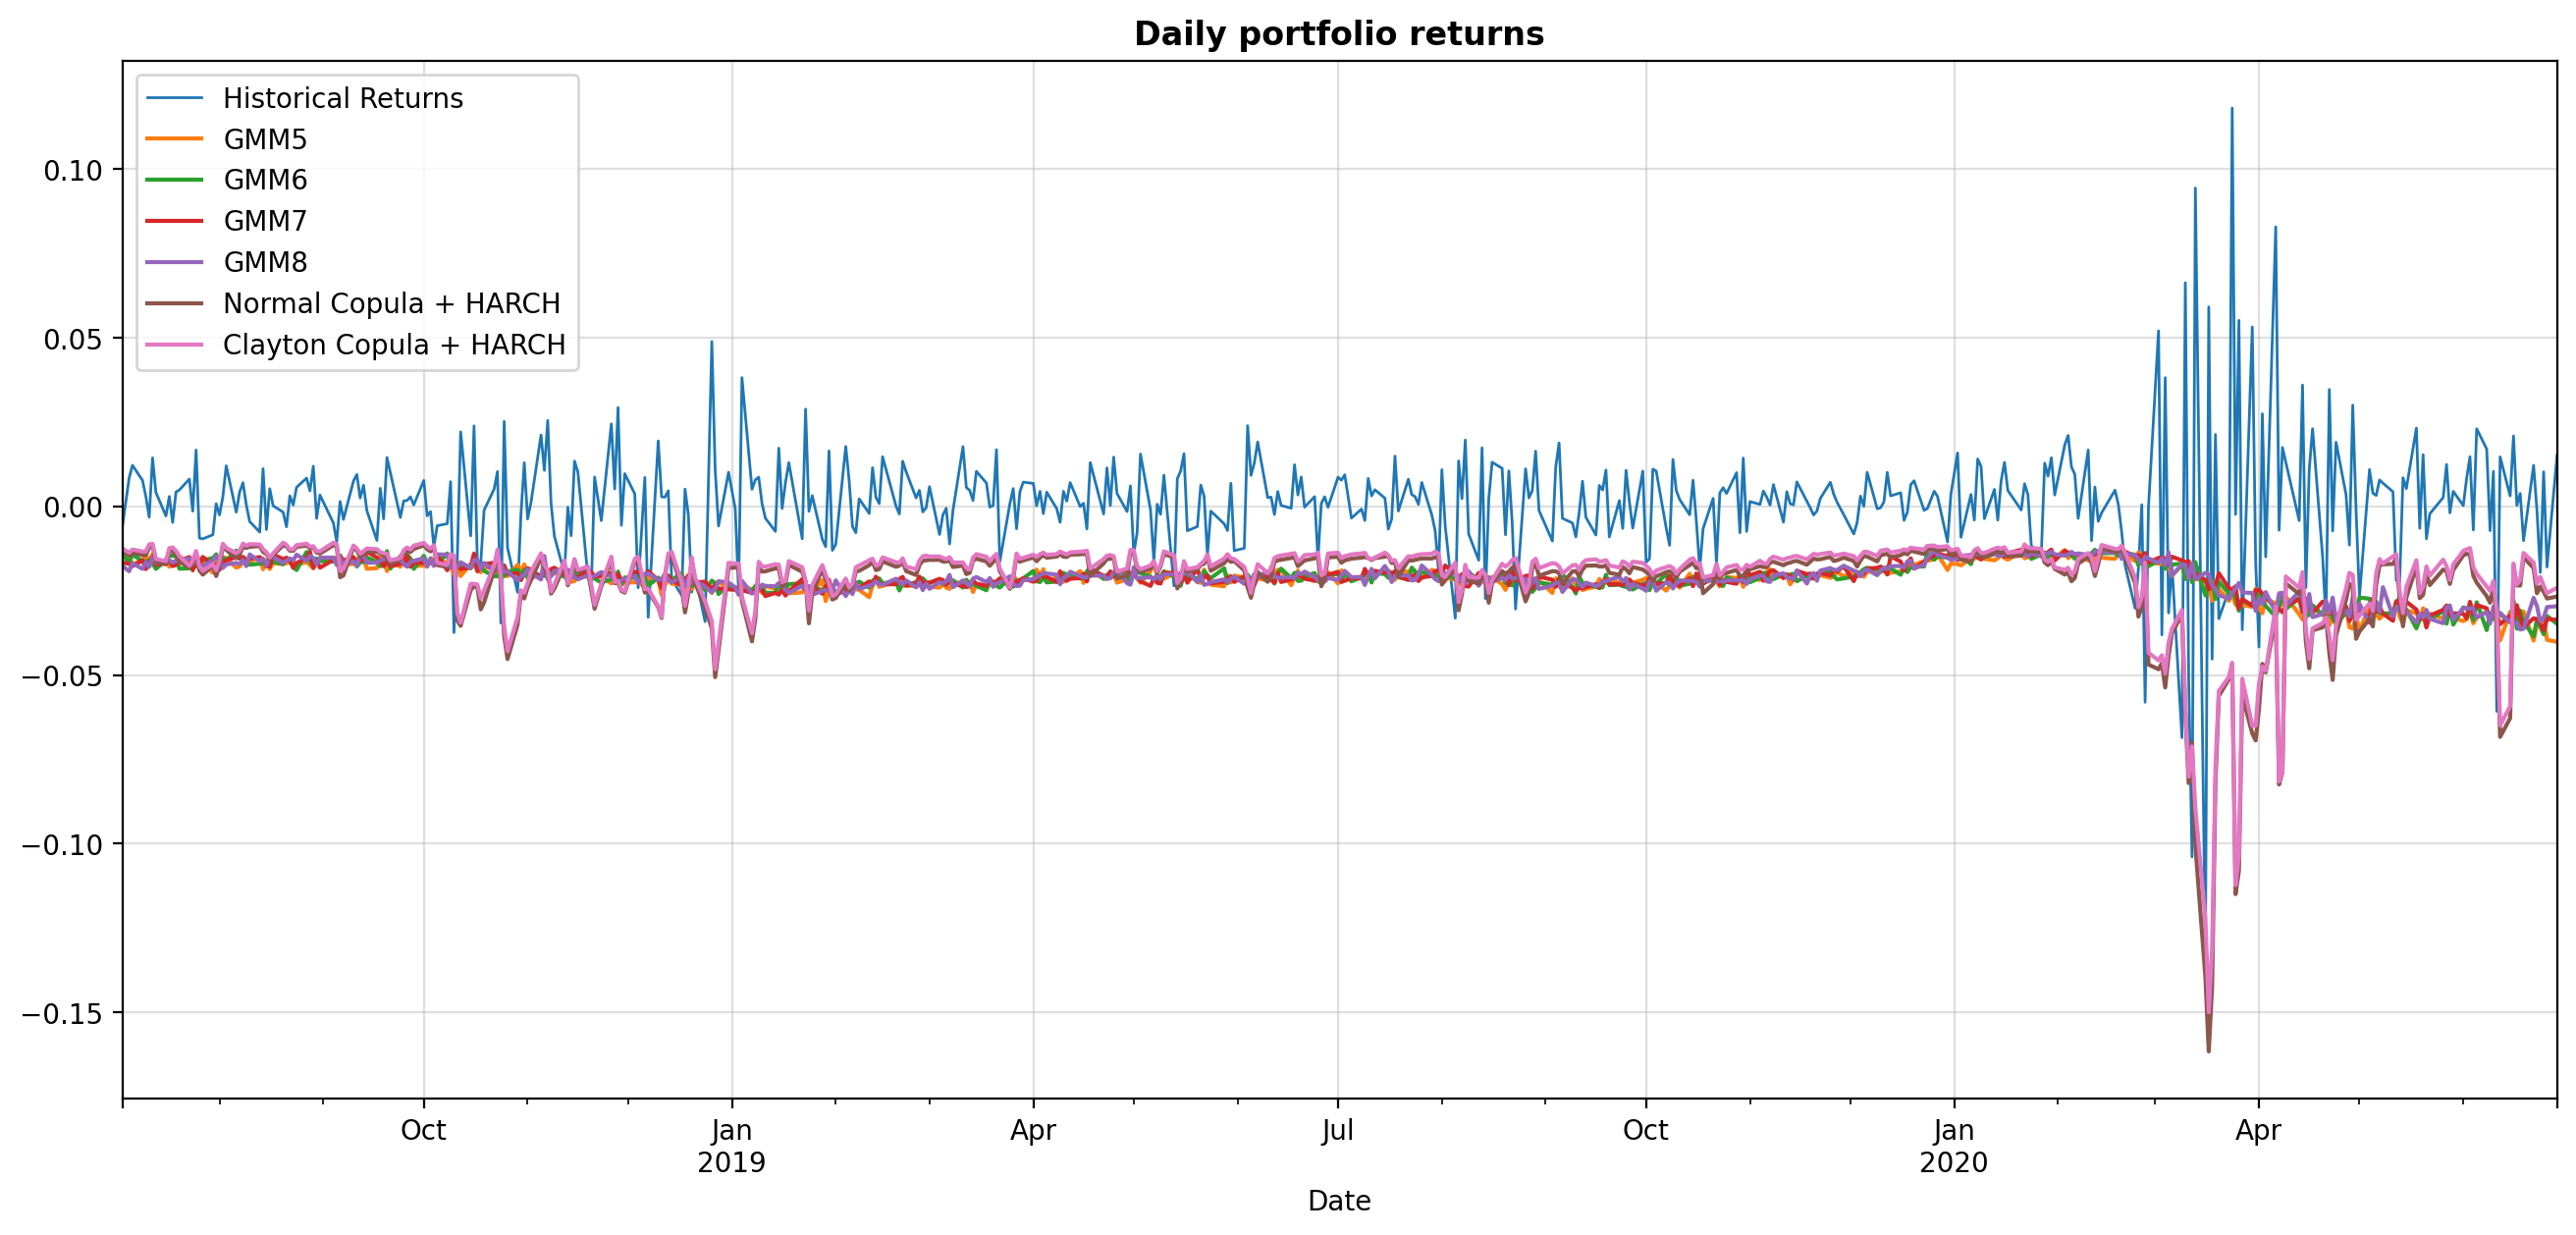

In [23]:
fig = plt.figure(figsize=(16, 7))
port_real_ret[252:].plot(linewidth=1, label='Historical Returns')
VaR_gmm_5.plot(label='GMM5')
VaR_gmm_6.plot(label='GMM6')
VaR_gmm_7.plot(label='GMM7')
VaR_gmm_8.plot(label='GMM8')

VaR_copula_norm.plot(label='Normal Copula + HARCH')
VaR_copula_clayton.plot(label='Clayton Copula + HARCH')

plt.title("Daily portfolio returns", weight="bold")
plt.grid(alpha=.4)
plt.legend()
plt.show()

### 2.2 Backtesting VaR

In [25]:
backtest_results = {'name' : [], 'hits_prop': [], 'p_value': []}

for VaR in [VaR_gmm_5, VaR_gmm_6, VaR_gmm_7, VaR_gmm_8, VaR_copula_norm, VaR_copula_clayton]:
    hits_prop, p_value = backtest(port_real_ret, VaR, .95)
    backtest_results['name'] += [VaR.name.replace('make_', '')]
    backtest_results['hits_prop'] += [round(hits_prop, 2)]
    backtest_results['p_value'] += [round(p_value, 3)]
backtest_results = pd.DataFrame(backtest_results).sort_values(by='hits_prop')

Backtesting make_gmm_simulations_5:
The proportion of hits is 6.19% instead of expected 5.0%
Two-sided p-val 0.218, one-sided: 0.133
green zone
----------------------------------------------------------------

Backtesting make_gmm_simulations_6:
The proportion of hits is 5.99% instead of expected 5.0%
Two-sided p-val 0.304, one-sided: 0.179
green zone
----------------------------------------------------------------

Backtesting make_gmm_simulations_7:
The proportion of hits is 6.79% instead of expected 5.0%
Two-sided p-val 0.08, one-sided: 0.0465
green zone
----------------------------------------------------------------

Backtesting make_gmm_simulations_8:
The proportion of hits is 6.39% instead of expected 5.0%
Two-sided p-val 0.151, one-sided: 0.0963
green zone
----------------------------------------------------------------

Backtesting make_copula_norm:
The proportion of hits is 5.59% instead of expected 5.0%
Two-sided p-val 0.538, one-sided: 0.3
green zone
-----------------------

In [26]:
backtest_results

,name,hits_prop,p_value
4,copula_norm,5.59,0.300
1,gmm_simulations_6,5.99,0.179
0,gmm_simulations_5,6.19,0.133
3,gmm_simulations_8,6.39,0.096
5,copula_clayton,6.59,0.068
2,gmm_simulations_7,6.79,0.046


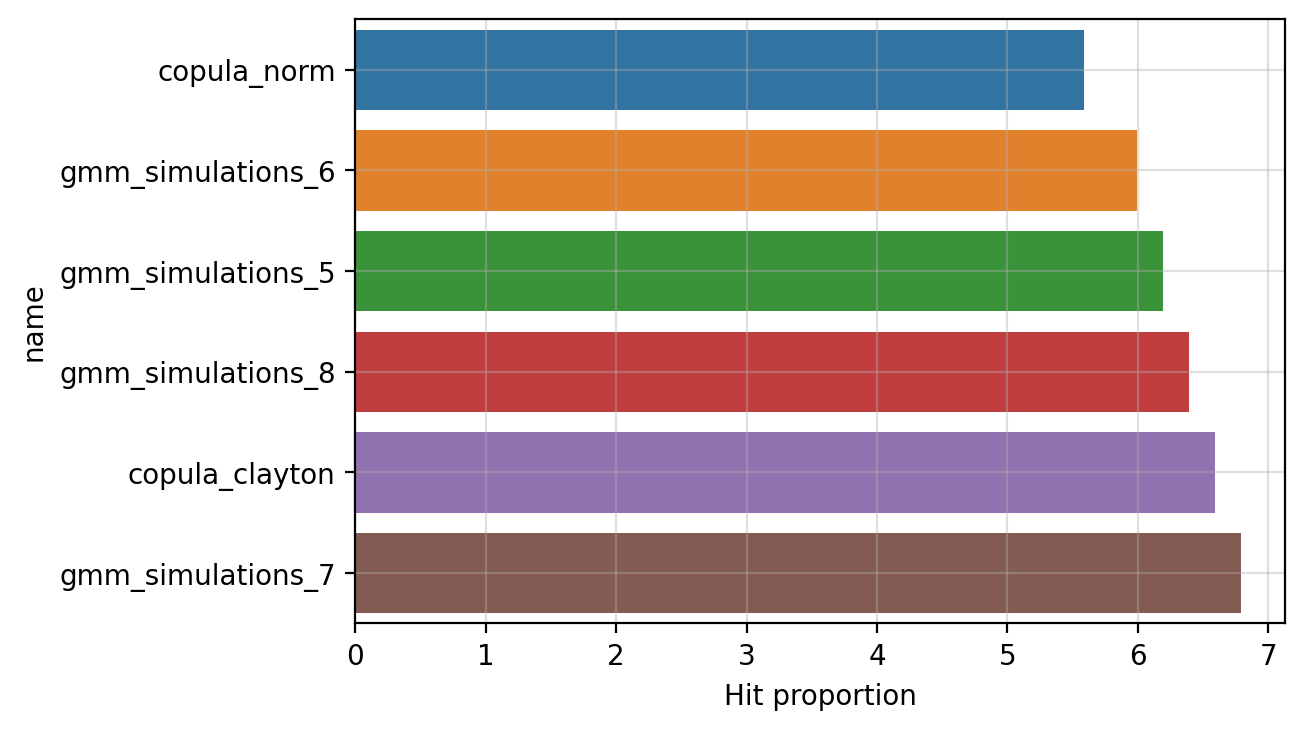

In [27]:
sns.barplot(x='hits_prop', y='name', data=backtest_results)
plt.grid(alpha=.4)
plt.xlabel('Hit proportion')
plt.show()

### 2.3 Conclusion
As we may see from the backtesting, the results of VaR modelling given by `Normal Copula + HARCH` shows the lowest hit proportion of `5.59` % with a p-value of `0.3`. As a consequence using this model allows modelling VaRs with the best precision compare to others.

---